# Import packages

In [2]:
from array import array
import itertools
import time
import math

import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Welcome to ROOTaaS 6.06/06


# File

In [3]:
Shower = "NN"
#Shower = "LO"
CorrectedP = False #FALSE FOR HARDPROBES

if (Shower == "NN"):
    pPb_File = 'InputData/13def_SE_GMB_new_Ratio.root'
    pp_File = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = [1,1,26.15]
    else:
        purity = [1, 1, 0.352546]
if (Shower == "LO"):
    pPb_File = 'InputData/13def_SE_L0_Correlation_GMB_Ratio.root'
    pp_File = 'InputData/17q_SE_L0_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = [1,1,0.221083]
    else:
        purity = [1,1,0.271083]
        
print purity
        
#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'

MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'

#RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/13def_SE_GMB_new_Ratio.root'
#RootFile = 'InputData/13def_SE_GMB_new_Ratio.root'
RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'


[1, 1, 0.352546]


# Define Bins and Purity


In [4]:
#FIXME: Read from Corr_config.yaml
#zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,12, 15]
NzT = 7
Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
oneminFake = [1,0.982,0.980,0.978,0.970,0.915,0.812]

#purity = [1,1,0.20]
#purity = [1,1,0.2989]
#purity_NN = 0.352546
#purity_LO = 0.271083

# Define Errors

In [5]:
p_error_sys = 0.06
p_error_stat = 0.028
eff_error = 0.05

# Prefix

In [6]:
prefix = '13def'
#prefix = '18b10a'
#prefix = '18b10a'
#prefix = '18b10a_15_20'
#prefix = '13def_15_20'
#prefix = 'p-Pb'
#prefix = 'P-bp'
#prefix = 'pp'
#prefix = 'pp_mix'
#prefix = 'pp_Same_Only'

## Plot Titles

In [7]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    #histo.SetTitle("#gamma - h : p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
    #               %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.SetTitle("#gamma - h: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"%(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitleSize(0.035)
    #histo.GetYaxis().SetTitleOffset(1)
    histo.GetXaxis().CenterTitle(1)
    histo.GetXaxis().SetTitleOffset(0.6)
    histo.GetXaxis().SetTitleSize(0.06)
    
    histo.GetYaxis().SetTitleSize(0.05)
    histo.GetYaxis().SetTitleOffset(1.5)
    
    ROOT.gStyle.SetOptStat("")
    ROOT.gStyle.SetPalette(ROOT.kViridis)
    histo.SetLineWidth(1)
    histo.SetLineColor(4)
    histo.SetMarkerColor(4)
    if not(DNN_Bool):
        histo.SetLineColor(2)
        histo.SetMarkerColor(2)

# Label

In [8]:
def DrawLabel2(Signal_DNN = True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    if (Signal_DNN == "inclusive"):
        #latex.SetTextSize(0.04)
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[1]{p-Pb + Pb-p Inclusive}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[1]{%s Inclusive}"%(prefix))
            
    elif (Signal_DNN):
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[4]{p-Pb + Pb-p Signal Region}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[4]{%s Signal}"%(prefix))
            
    else:
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[2]{p-Pb + Pb-p Bkgd Region}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[2]{%s Bkgnd}"%(prefix))

<sup> **Note** Scaling is done cell by cell (despite Axis title here) for accurate subtraction<sup>

# ZYAM

In [9]:
def Subtract_ZYAM (PhiProjection):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)

    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

In [10]:
def ZYAM_Line(hsig):
    Z_min = (hsig.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (hsig.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam_value = hsig.Integral(Z_min,Z_max)/(Z_N)
    
    #Errors
    Z_Error = 0
    for NError in range(Z_min,Z_max+1):
        Z_Error += (hsig.GetBinError(NError))**2
    Z_Error = math.sqrt(Z_Error)
    
    #LE TGraph
    NBins = hsig.GetSize()-2
    ZYAM = ROOT.TGraphErrors()
    for NBin in range(0,NBins+1):
        ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
        ZYAM.SetPointError(NBin,0,Z_Error)
    
    #print "zyam line value: ",zyam_value 
    #ZYAM.SetFillColorAlpha(7, 0.6);
    ZYAM.SetFillColor(7)
    SetOwnership(ZYAM, 0)
    
    #print Z_min, Z_max, Z_N
    #ZYAM = ROOT.TLine(0,zyam_value,math.pi,zyam_value)
    #ZYAM.SetLineColorAlpha(7, 0.9)
    #ZYAM.SetLineWidth(5)
    #SetOwnership(ZYAM, 0)
    
    return zyam_value,Z_Error
    #return ZYAM

# N Triggers

In [11]:
def Get_NTriggers(filename,prfx,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (prfx =="18b10a"):
            NTriggers = ntrig_histo.Integral(0,-1)
        else:
            NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

# Large $\eta$

In [54]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True):
    file = ROOT.TFile(filename)
    
    DoAverage = False
    
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        
        LE_Projection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.2),Eta_Axis.FindBin(-0.8))
                                        #10*zTbins[izt+1]),5,11)
        LE_Projection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.2))
  
        ntriggers = Get_NTriggers(filename,prefix, ipt, Signal_DNN)  
        if not(ntriggers == None):
            LE_Projection.Scale(1.0/ntriggers) #per trigger yield
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        #print DNN_Rgn

        if (DoAverage):
            histo2D_1 = file.Get('DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            histo2D_2 = file.Get('DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        else:
            histo2D_1 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            histo2D_2 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        #Project
        Eta_Axis = histo2D_1.GetYaxis()
  
        ntriggers_DNN2 = Get_NTriggers(filename,prefix, ipt, False) 
        
        if (DoAverage):
            ntriggers_DNN1 = Get_NTriggers(filename,prefix, ipt, True) 
        else:
            ntriggers_DNN1 = Get_NTriggers(filename,prefix, ipt, Signal_DNN)   
    
        LE_Projection = histo2D_1.ProjectionX('NegEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
        
        LE_Projection_pos = histo2D_1.ProjectionX('PosEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
        
        LE_Projection_DNN2 = histo2D_2.ProjectionX('NegEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))

        LE_Projection_DNN2_pos = histo2D_2.ProjectionX('PosEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
        
        LE_Projection.Scale(1.0/ntriggers_DNN1)
        LE_Projection_pos.Scale(1.0/ntriggers_DNN1)
        
        LE_Projection_DNN2.Scale(1.0/ntriggers_DNN2)
        LE_Projection_DNN2_pos.Scale(1.0/ntriggers_DNN2)
        
        if (DoAverage):
            LE_Projection.Add(LE_Projection_DNN2,1.0)
            LE_Projection.Scale(0.5)
        
            LE_Projection_pos.Add(LE_Projection_DNN2_pos,1.0)
            LE_Projection_pos.Scale(0.5)
        
    
    #Add,scale 
    LE_Projection.SetDirectory(0)
    LE_Projection.Add(LE_Projection_pos,1)
    LE_Projection.Rebin(2)
    LE_Projection.Scale(1.0/1.2) #scale by eta region
    #LE_Projection.Scale(1.0/2.8)
    Plot1D(LE_Projection,ipt,izt,Signal_DNN)
    LE_Projection.SetMarkerStyle(25)
    LE_Projection.SetLineColorAlpha(1,0.1)
    #LE_PhiProjection.SetMarkerSize(3)
    LE_Projection.SetMarkerColor(1)
        
    #Legend
    #legend = ROOT.TLegend(0.64,0.78,0.89,0.88)
    LE_Projection.SetLineColorAlpha(1,0.9) #8 for light green
    #legend.AddEntry(LE_PhiProjection, "0.8 <|#eta| < 1.4","p")
    SetOwnership(legend, 0)
    file.Close()
    return LE_Projection

#### Simplify above with calls to getPhiProjection()

In [13]:
def GetLE_Line(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    #print LE_min,LE_max
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    print LE_value
    
    #Errors
    Temp_Error = 0
    for NError in range(LE_min,LE_max+1):
        Temp_Error += (LE_Proj.GetBinError(NError))**2
    
    Temp_Error = math.sqrt(Temp_Error)
    LE_Error = Temp_Error/(LE_max-LE_min+1)
    #LE_Error = LE_Error/math.sqrt(10000)
    
    #LE TGraph
    NBins = LE_Proj.GetSize()-2
    LE_Line = ROOT.TGraphErrors()
    for NBin in range(0,NBins+1):
        LE_Line.SetPoint(NBin,(NBin*math.pi/NBins),LE_value)
        LE_Line.SetPointError(NBin,0,LE_Error)
    
    #print "LE Line Value: ","%1.3f"%(LE_value)," +/- ","%1.3f"%(LE_Error)
    
    #LE_Line.SetFillColorAlpha(1, 0.9);
    LE_Line.SetFillColor(17);
    #LE_Line = ROOT.TLine(0,LE_value,math.pi,LE_value)
    #LE_Line.SetLineColorAlpha(1, 0.9)
    #LE_Line.SetLineWidth(5)
    SetOwnership(LE_Line, 0)
    #legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    legend.AddEntry(LE_Line, "0.8 <|#eta| < 1.4","l")
    SetOwnership(legend, 0)
    return LE_Line,legend

In [14]:
def GetLE_Val(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    Temp_Error = 0
    for NError in range(LE_min,LE_max+1):
        Temp_Error += (LE_Proj.GetBinError(NError))**2
        
    Temp_Error = math.sqrt(Temp_Error)
    LE_Error = Temp_Error/(LE_max-LE_min+1)
    
    return LE_value, LE_Error

In [15]:
def Subtract_LE(PhiProjection,LE_Proj,DoSys=False):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Error = 0
    for NError in range(LE_min,LE_max+1):
        LE_Error += (LE_Proj.GetBinError(NError))**2
    #print "Quad Sum of Errors:",LE_Error
    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/(LE_N)
    
    sumerror=0
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            if (DoSys):
                new_y_error = math.sqrt(LE_Error**2) #Propagate the systematic by itself
                #new_y_error = 0
            else:
                new_y_error = y_error    
            PhiProjection.SetBinError(i,new_y_error)

    #print math.sqrt(sumerror)

#### Check

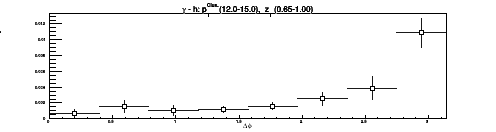

(0.0012535391869423927, 0.0003393770011155075)

In [16]:
LE,legend = GetLEProj(RootFile, 2, 6, True)
cav = ROOT.TCanvas("cav","cav", 500,160)
LE.Draw()
legend.Draw()
cav.Draw()
#GetLE_Line(LE)
GetLE_Val(LE)

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [30]:
#Obtains the phi projection withen the eta region (|eta|<0.6)
#def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True, doZYAM=True,DoSys=False):
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    #FIXME: Subtraction ond systematics will be handled separatly from now on
    file = ROOT.TFile(filename)

    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                         #100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        #100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))

    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/1.2)
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,prfx,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers)
        
    
    #Will deprecate soon
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    
    file.Close()
    return PhiProjection

In [32]:
for ztbin in range(6):
    GetPhiProj(RootFile,prefix,2,ztbin,True) #Signal=Yes,ZYAM=No,SysError=No.

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

# Compare ZYAM and LE

In [38]:
delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
for ipt in range (3):
    file1=pp_File
    if (ipt > 0): continue
    ipt = ipt+2
    for izt in range (6):
        Sig_LE_Proj = GetLEProj(file1, ipt, izt, False)
        S_LE, S_LE_Error = GetLE_Val(Sig_LE_Proj)
        
        Bkg_LE_Proj = GetLEProj(file1, ipt, izt, False)
        B_LE, B_LE_Error = GetLE_Val(Bkg_LE_Proj)       
        
        hsig =  GetPhiProj(file1,prefix,ipt,izt,True)
        hbkg = GetPhiProj(file1,prefix,ipt,izt,False)
        
        sig_line = ZYAM_Line(hsig)
        bkg_line = ZYAM_Line(hbkg)
        NBins = hsig.GetSize()-2
        
        print izt,": %.6f"%(S_LE_Error)


0 : 0.002372
1 : 0.001959
2 : 0.001422
3 : 0.000882
4 : 0.000492
5 : 0.000670


### Side By Side

In [55]:
#delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
delta_phi_centers= np.array([0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
phi_width = [0.39269908169872414/2]*len(delta_phi_centers)

def SideSide(Region):
        #prfx= "p-Pb"
        #iFile = pPb_File
        prfx= "pp"
        iFile = pp_File       
        #prefix = "18b10a"
        #print RootFile
        Uncorr = True
        DoSub = False
        DoSys = False
        ptbin = 0
        ptbin = ptbin+2;
        sig_2d = []
        bkg_2d = []
        axs = []     
        fig = plt.figure(figsize=(34,17))
        
        for ztb in range(4):
            #zt = ztb
            ztbin = ztb+2 
            if (Region=="regions"):              
            #grab
                hsig = GetPhiProj(iFile,prfx,ptbin,ztbin,True) #[DNN],[Subtraction Bool] [DoSysErr]
                hbkg = GetPhiProj(iFile,prfx,ptbin,ztbin,False)

                #canvases.cd(ztbin+1)
                Sig_ZYAM,Sig_ZYAM_E= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
                LE_sig = GetLEProj(iFile, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                S_LE_Val,S_LE_E = GetLE_Val(LE_sig)
                #S_LE_Val = LE_Line.GetMean(2) ##################################


            if (Region=="inclusive"):
                    hsig = GetPhiProj(iFile,prefix,ptbin,ztbin,"inclusive")
                
            #Background
            if (Region=="regions"): 
                BKG_ZYAM,BKG_ZYAM_E = ZYAM_Line(hbkg)
                LE_bkg = GetLEProj(iFile, ptbin, ztbin, False)
                LE_bkg_Line,temp = GetLE_Line(LE_bkg)
                B_LE_Val,B_LE_E = GetLE_Val(LE_bkg)
                    
                sig_list = []
                sig_eta_list = []
                bkg_list = []
                bkg_eta_list = []
                sig_list_error = []
                bkg_list_error = []
                bkg_eta_error = []
                sig_eta_error = []
                for bin in range(2,9):
                    sig_list.append(hsig.GetBinContent(bin))
                    sig_list_error.append(hsig.GetBinError(bin))
                    sig_eta_list.append(LE_sig.GetBinContent(bin))
                    sig_eta_error.append(LE_sig.GetBinError(bin))
                    
                    bkg_list.append(hbkg.GetBinContent(bin))
                    bkg_list_error.append(hbkg.GetBinError(bin))
                    bkg_eta_list.append(LE_bkg.GetBinContent(bin))
                    bkg_eta_error.append(LE_bkg.GetBinError(bin))

                #print sig_list    
                ax = fig.add_subplot(2,4,(2*ztb+1))
                #ax = fig.add_subplot(1,2,1)
                fsize = 20
                
                #sig
                ax.plot(delta_phi_centers,sig_list,'bo',ms=10)
                s_plot = ax.errorbar(delta_phi_centers,sig_list,xerr=phi_width,yerr=sig_list_error,fmt=None,ecolor='b',label='Signal Region (stat. error)')

                ax.plot(delta_phi_centers,sig_eta_list,'s',color="Grey",alpha=0.6,ms=10)
                s_le_plot = ax.errorbar(delta_phi_centers,sig_eta_list,xerr=phi_width,yerr=sig_eta_error,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")
                
                plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
                plt.xticks(fontsize=(fsize))
                plt.xlim((0.39269908169872414,3.14159))
                plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+4)
                plt.ylim((0,1.2*max(sig_eta_list)))
                empt, = ax.plot([], [], ' ')
                empt2, = ax.plot([],[],' ')
                plt.yticks(fontsize=fsize)

                fill_x = [0,3.14149]
                s_z_line = ax.fill_between(fill_x, Sig_ZYAM-Sig_ZYAM_E,Sig_ZYAM+Sig_ZYAM_E,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
                s_le_line = ax.fill_between(fill_x, S_LE_Val-S_LE_E,S_LE_Val+S_LE_E,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

                leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Signal Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
                    'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[ztbin],zTbins[ztbin+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                    loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=15,frameon=False,numpoints=1)
                if (prfx == 'pp'):
                    leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(prfx))
                else:
                    leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(prfx))                
                plt.setp(leg.get_title(),fontsize=15)
                
                
                #bkg
                ax = fig.add_subplot(2,4,(2*ztb+2))
                #ax = fig.add_subplot(1,2,1)
                plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
                plt.xticks(fontsize=(fsize))
                plt.xlim((0.39269908169872414,3.14159))
                plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+4)
                plt.ylim((0,1.2*max(bkg_eta_list)))
                plt.yticks(fontsize=fsize)

                fill_x = [0,3.14149]
                b_z_line = plt.fill_between(fill_x, BKG_ZYAM-BKG_ZYAM_E,BKG_ZYAM+BKG_ZYAM_E,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
                b_le_line = plt.fill_between(fill_x, B_LE_Val-B_LE_E,B_LE_Val+B_LE_E,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

                ax.plot(delta_phi_centers,bkg_list,'ro',ms=10)
                b_plot = ax.errorbar(delta_phi_centers,bkg_list,xerr=phi_width,yerr=bkg_list_error,fmt=None,ecolor='r')

                plt.plot(delta_phi_centers,bkg_eta_list,'s',color="Grey",alpha=0.6,ms=10)
                
                b_le_plot =plt.errorbar(delta_phi_centers,bkg_eta_list,xerr=phi_width,yerr=bkg_eta_error,fmt=None,ecolor='Grey',alpha=0.8)
                leg = ax.legend([b_plot,b_le_plot,b_le_line,b_z_line,empt,empt2],['Bkg Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
                    'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[ztbin],zTbins[ztbin+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
                    loc='best',fontsize=15,frameon=False,numpoints=1)
                if (prfx == 'pp'):
                    leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(prfx))
                else:
                    leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(prfx))
                plt.setp(leg.get_title(),fontsize=15)
                fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(prfx,ztb), bbox_inches='tight')
        return
#myText(.2,.2,"hello_%i"%number,1) ‹›

0.0609484192812
0.0610337383446
0.0251657513793
0.0232627236549
0.00692650222659
0.00784844409628
0.00347271526389
0.00470509197219


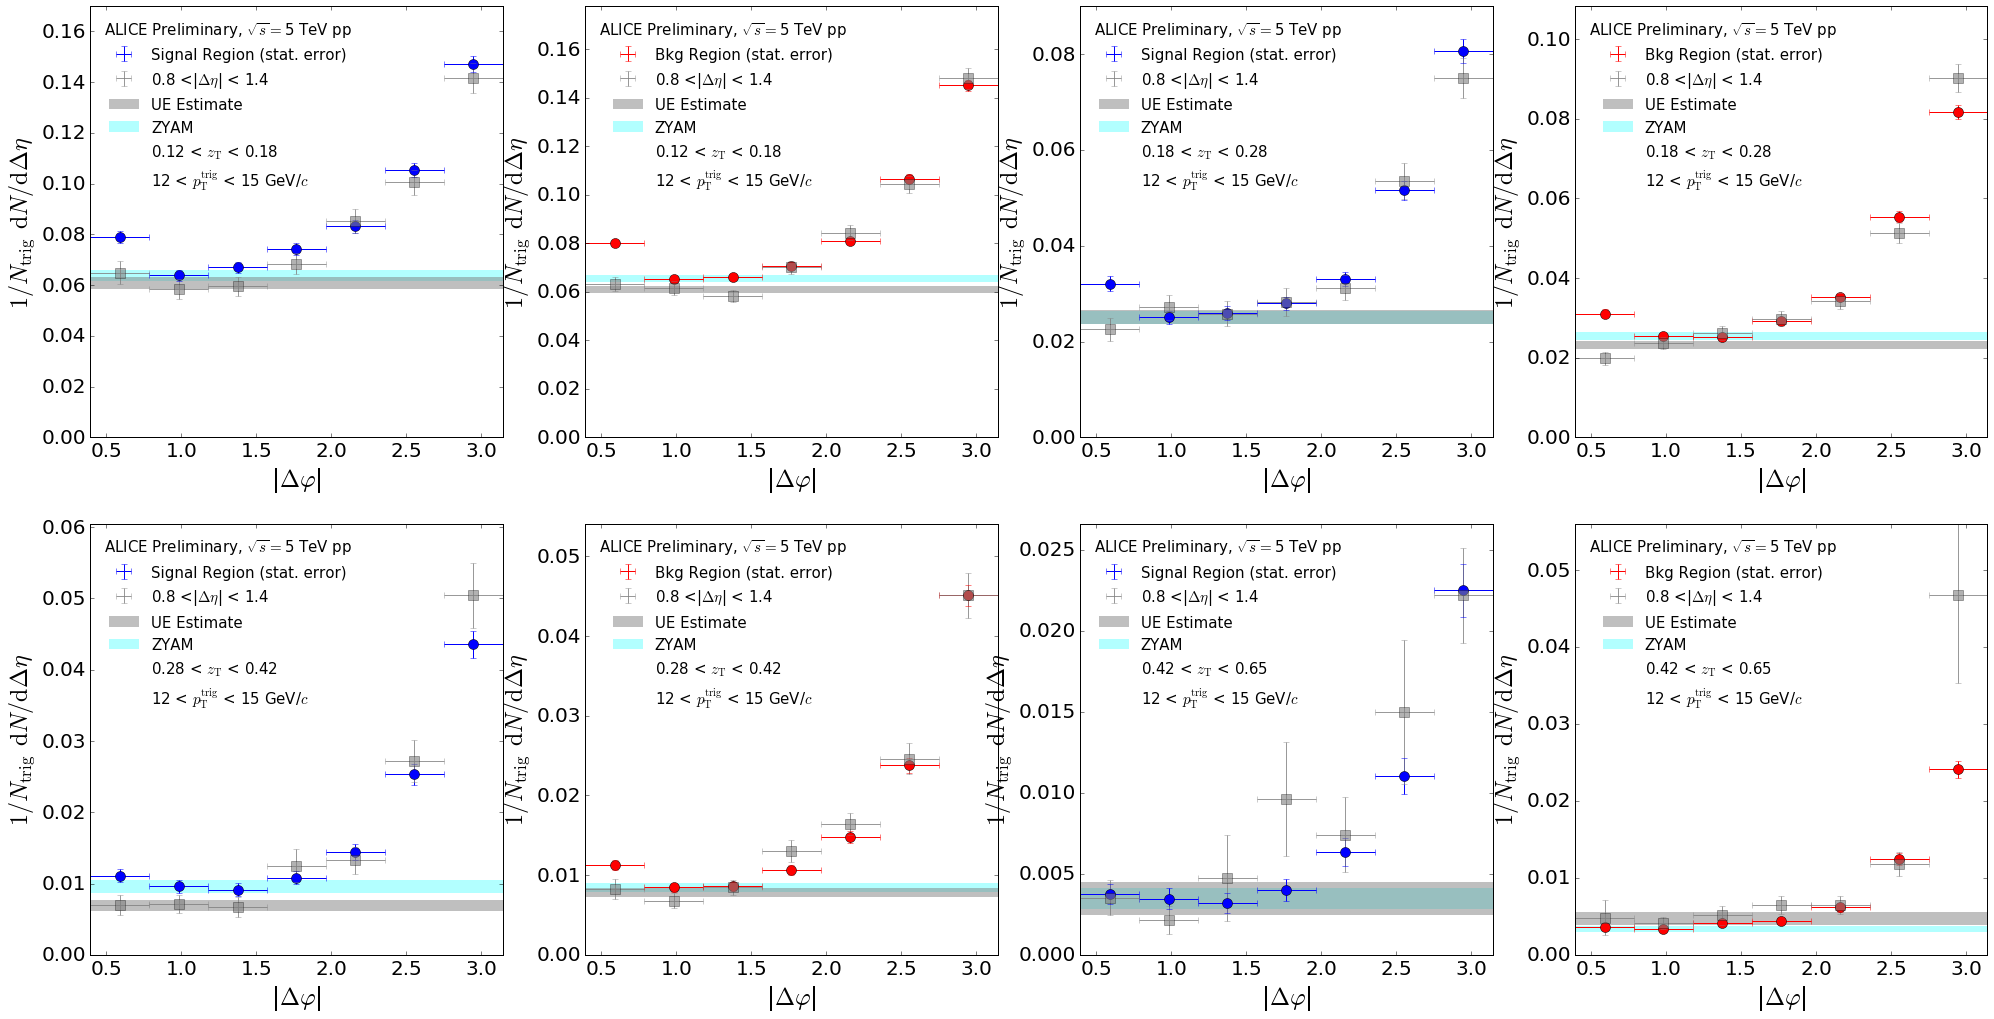

In [56]:
SideSide("regions")
#SideSide("inclusive") [0.016,0.416]

In [21]:
def DrawLabel(NTriggers,ptbin):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    latex.DrawLatex(0.6,0.81, "#color[2]{purity = %1.2f}"%(purity[ptbin]))
    #latex.DrawLatex(0.12,0.85, "#color[2]{no purity scaling}")
    latex.DrawLatex(0.22,0.81, "#color[4]{%1.0f Triggers}"%(NTriggers))

In [22]:
def DrawLabel3(NTriggers,DoSub=True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    if (DoSub):
        latex.SetTextSize(0.04)
        #latex.DrawLatex(0.12,0.85, "#color[4]{%1.0f Triggers}"%(NTriggers))
        if (prefix=="13def"):
            latex.DrawLatex(0.22,0.85, "#color[4]{pPb+Pbp After Subtraction}")
        else:
            latex.DrawLatex(0.22,0.85, "#color[4]{%s After Subtraction}"%(prefix))
    else: 
        if (prefix=="13def"):
            latex.DrawLatex(0.22,0.85, "#color[4]{p-Pb+Pb-p Signal Region}")
            latex.DrawLatex(0.6,0.85, "#color[2]{(1-p)Bkgnd Region}")
        else:
            latex.DrawLatex(0.22,0.85, "#color[4]{%s Signal Region}"%(prefix))
            latex.DrawLatex(0.6,0.85, "#color[2]{%s (1-p)Bkgnd Region}"%(prefix))

# Calculate Purity Uncertainty

In [23]:
def Get_P_Error(filename,prfx,p_err,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    P_Error = []
    FF_P = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_minp = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_minp = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_maxp = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_maxp = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        
            #p_error = math.sqrt(0.028**2 + 0.06**2)
            p_min = purity[ptbin]-p_err
            p_max = purity[ptbin]+p_err

            Background_maxp.Scale((1-p_max)/p_max)
            Signal_maxp.Scale(1/p_max)
            #Background_maxp.Scale(1-p_max)
            Signal_maxp.Add(Background_maxp,-1)
            #Signal_maxp.Scale(1/p_max)
            #Signal_maxp.
            
            
            Background_minp.Scale((1-p_min)/p_min)
            Signal_minp.Scale(1/p_min)
            Signal_minp.Add(Background_minp,-1) 
            
            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)

            y_min = -1.1*abs(Signal_minp.GetMinimum())
            y_max = 1.2*Signal_maxp.GetMaximum()
            
            Signal_maxp.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_maxp.Draw()
            Signal_minp.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_minp.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{p+#sigma_{p}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{p = 0.35}")
            latex.DrawLatex(0.14,0.74, "#color[2]{p-#sigma_{p}}")

            #Signal.Add(Signal2,-1)
            p_error = []
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_maxp.GetBinContent(i)-Signal_minp.GetBinContent(i))/2
                sum_min += Signal_minp.GetBinContent(i)
                sum_max += Signal_maxp.GetBinContent(i)
                #print Signal_minp.GetBinContent(i)
            #print "sum_min: ",sum_min
            #print sum_min
        
            #print ""
            #print "max",sum_max
            #print "min",sum_min
            #delta = (sum_max - sum_min)/(2)
            #print "Delta/2 = ",delta
            #print "Sum over phi = ",sum_phi
            p_error.append(delta/sum_phi)
            #print sum_max        
            #print "Relative:",abs(delta/sum_phi*100),"%"
            #print "%1.2f"%(abs(delta/sum_phi)*100)
            P_Error.append(delta)
            #print P_Error[ztbin]
            FF_P.append(sum_phi)
        canvases.Update()
        #canvases.Draw()
        canvases.SaveAs('pics/%s_P_sys_Var.pdf'%(prfx))
    return FF_P,P_Error

In [24]:
File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
File1 = pPb_File
prfx1 = '13def'
pPb_FF_P, pPb_P_Error = Get_P_Error(File1,prfx1,0.06,True,True,True)
pPb_FF_P, pPb_P_stat_Error = Get_P_Error(File1,prfx1,0.028,True,True,True)


File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
prfx2 = 'pp'
pp_FF_P, pp_P_Error = Get_P_Error(File2,prfx2,0.06,True,True,True)
pp_FF_P, pp_P_stat_Error = Get_P_Error(File2,prfx2,0.028,True,True,True)

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: Canv_Side_Side_2
Info in <TCanvas::Print>: pdf file pics/13def_P_sys_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/13def_P_sys_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_P_sys_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_P_sys_Var.pdf has been created


# Calculate Efficiency Uncertainty

In [25]:
def Get_Eff_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    Efficiency = 0.85
    Eff_Err = 0.05
    
    Eff_Error = []
    FF_Eff = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_min = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_min = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_max = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_max = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        
            #p_error = math.sqrt(0.028**2 + 0.06**2)

            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)
            Signal_max.Scale(1/(Efficiency+Eff_Err))

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 
            Signal_min.Scale(1/(Efficiency-Eff_Err))

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            Signal.Scale(1/Efficiency)
            
            y_min = 1.2*Signal_max.GetMinimum()
            y_max = 1.2*Signal_min.GetMaximum()
            Signal_max.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_max.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_min.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{Eff+#sigma_{eff}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{Eff}")
            latex.DrawLatex(0.14,0.74, "#color[2]{Eff-#sigma_{eff}}")
            

            #Signal.Add(Signal2,-1)
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_max.GetBinContent(i)-Signal_min.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)

            #print abs(delta/sum_phi)
            Eff_Error.append(delta)
            FF_Eff.append(sum_phi)
        canvases.Update()
        #canvases.Draw()
        canvases.SaveAs('pics/%s_Eff_Var.pdf'%(prfx))
    return FF_Eff,Eff_Error

In [26]:
#File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
#File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
File1 = pPb_File
prfx1 = '13def'
pPb_FF_Eff, pPb_Eff_Error = Get_Eff_Error(File1,prfx1,True,True,True)
File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
prfx2 = 'pp'
pp_FF_Eff, pp_Eff_Error = Get_Eff_Error(File2,prfx2,True,True,True)
#MC_FF_Eff, MC_Eff_Error = Get_Eff_Error(MC_File,'18b10a',True,False,False)

MC_FF_Eff, MC_Eff_Error = Get_Eff_Error(MC_File,'18b10a,',True,False,True)

Info in <TCanvas::Print>: pdf file pics/13def_Eff_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_Eff_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/18b10a,_Eff_Var.pdf has been created


In [27]:
def Get_Assym_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    File1 = "InputData/13f_SE_Correlation_GMB_Ratio.root"
    File2 = "InputData/13de_4L_SE_Correlation_GMB_Ratio.root"
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    Assym_Error = []
    FF_Assym = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_min = GetPhiProj(File1,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_min = GetPhiProj(File1,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_max = GetPhiProj(File2,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_max = GetPhiProj(File2,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        

            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)
            #Signal_max.Scale(1/(Efficiency+Eff_Err))

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 
            #Signal_min.Scale(1/(Efficiency-Eff_Err))

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            #Signal.Scale(1/Efficiency)
            
            #y_min = 1.2*Signal_max.GetMinimum()
            #y_max = 1.2*Signal_min.GetMaximum()
            #Signal_max.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_max.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_min.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{13de}")
            latex.DrawLatex(0.14,0.79, "#color[3]{Eff}")
            latex.DrawLatex(0.14,0.74, "#color[2]{13f}")
            

            #Signal.Add(Signal2,-1)
            
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal.GetBinContent(i)-Signal_max.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)

            #print abs(delta/sum_phi)
        Assym_Error.append(delta)
        FF_Assym.append(sum_phi)
        canvases.Update()
        #canvases.Draw()
        canvases.SaveAs('pics/%s_Assym_Var.pdf'%(prfx))
    return FF_Assym,Assym_Error

In [28]:
File = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
prfx = '13def'
#File = "InputData/13de_4L_SE_Correlation_GMB_Ratio.root"
#FF_Assym, Eff_Assym = Get_Assym_Error(File,prfx,True,True,True)

# Calculate UE Subtraction Uncertainty

In [29]:
def Subtract_LE2(PhiProjection,LE_Proj,DoSys=False,doMax=True):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Error = 0
    for NError in range(LE_min,LE_max+1):
        LE_Error += (LE_Proj.GetBinError(NError))**2

    LE_Error = math.sqrt(LE_Error)
    print LE_Error
    LE_Error = LE_Error/(LE_N)
    
    if (doMax):
        print LE_Error
        LE = LE+LE_Error
    else:
        LE = LE-LE_Error
        
    sumerror=0
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            if (DoSys):
                #new_y_error = math.sqrt(LE_Error**2) #Propagate the systematic by itself
                new_y_error =  0
            else:
                new_y_error = 0    
            PhiProjection.SetBinError(i,new_y_error)

    #print math.sqrt(sumerror)

In [30]:
def Subtract_ZYAM2 (PhiProjection, doMax=True):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)
    Z_Error = 0
    for nz in range(Z_min,Z_max+1):
        #print PhiProjection.GetBinError(nz)
        Z_Error += (PhiProjection.GetBinError(nz))**2
    Z_Error = math.sqrt(Z_Error)
    if (doMax):
        zyam = zyam+Z_Error
    else:
        zyam = zyam-Z_Error
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            new_y_error = 0
            PhiProjection.SetBinError(i,new_y_error)

In [31]:
def GetPhiProj2(filename,prfx,ipt, izt, Signal_DNN=True, doZYAM=True,DoSys=False,doMax=True):
    file = ROOT.TFile(filename)

    if (DoSys):
        SysE = "_Stat+Sys"
    else:
        SysE = ""
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
                                        #10*zTbins[izt+1]),5,11)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
                                        #10*zTbins[izt+1]),5,11)
    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/2.8) #scale by eta region
    #PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename,prfx,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        #Subtract_LE2(PhiProjection,LE_Proj,DoSys,doMax)#Stat+Sys Bool (True, False = Just Stat.)
        Subtract_ZYAM2(PhiProjection,doMax)
    
    #file.Close()
    return PhiProjection

In [32]:
def Get_LE_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,3)

        LE_Error = []
        FF_LE = []
        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_max = GetPhiProj2(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys,True) #High DNN (True) MAX LE
            Background_max = GetPhiProj2(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys,True) #Low DNN (False) MAX LE
            Signal_min = GetPhiProj2(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys,False) #High DNN (True) MIN LE
            Background_min = GetPhiProj2(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys,False) #Low DNN (False) MIN LE

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)
            nbins = Signal.GetSize()-2
            if not(filename == MC_File):

                Background_max.Scale((1-purity[ptbin])/purity[ptbin])
                Signal_max.Scale(1/purity[ptbin])
                Signal_max.Add(Background_max,-1)

                Background_min.Scale((1-purity[ptbin])/purity[ptbin])
                Signal_min.Scale(1/purity[ptbin])
                Signal_min.Add(Background_min,-1) 

                Background.Scale((1-purity[ptbin])/purity[ptbin])
                Signal.Scale(1/purity[ptbin])
                Signal.Add(Background,-1)
            
            y_min = 1.2*Signal_max.GetMinimum()
            y_max = 1.2*Signal_min.GetMaximum()
            
            Signal_min.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_min.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_max.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{LE+#sigma_{LE}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{LE}")
            latex.DrawLatex(0.14,0.74, "#color[2]{LE-#sigma_{LE}}")

            #Signal_min.Add(Signal_max,-1)
            #LE_error = []
            
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_min.GetBinContent(i)-Signal_max.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)
            LE_Error.append(delta)
            FF_LE.append(sum_phi)
            #print "%1.2f"%(delta/sum_phi * 100)
        canvases.Update()
        #canvases.Draw()
        canvases.SaveAs('pics/%s_LE_Var.pdf'%(prfx))
    return FF_LE, LE_Error

In [33]:
#File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
File1 = pPb_File
prfx1 = '13def'
pPb_LE_Eff, pPb_LE_Error = Get_LE_Error(File1,prfx1,True,True,True)
pPb_LE_Error = [1,1,0.0057,0.002857,0.002857,0.0012857,0.002857]
#File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
prfx2 = 'pp'
pp_LE_Eff, pp_LE_Error = Get_LE_Error(File2,prfx2,True,True,True)
pp_LE_Error = [0.003,0.003,0.000567,0.00426,0.00284,0.00241
               ,0.001]
print pp_LE_Error
MC_LE_Eff, MC_LE_Error = Get_LE_Error(MC_File,'18b10a',True,False,True)
print MC_LE_Error


[0.003, 0.003, 0.000567, 0.00426, 0.00284, 0.00241, 0.001]
[0.015927059756568884, 0.011061475916569266, 0.008681640724754344, 0.003935227061524831, 0.0019573963629633453, 0.0008106113357555895, 0.0]


Info in <TCanvas::Print>: pdf file pics/13def_LE_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_LE_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/18b10a_LE_Var.pdf has been created


# Summarize Errors

In [34]:
pp_Systematic = []
for i in range (NzT):
    pp_Systematic.append(math.sqrt(pp_LE_Error[i]**2 + pp_P_Error[i]**2 + pp_P_stat_Error[i]**2 + pp_Eff_Error[i]**2))
print pp_Systematic

pPb_Systematic = []
for i in range (NzT):
    pPb_Systematic.append(math.sqrt(pPb_LE_Error[i]**2 + pPb_P_Error[i]**2 + pPb_P_stat_Error[i]**2 + pPb_Eff_Error[i]**2))
print pPb_Systematic
MC_Systematic = []
for i in range (NzT):
    MC_Systematic.append(math.sqrt(MC_LE_Error[i]**2 + MC_Eff_Error[i]**2))
print MC_Systematic

[0.017115095078815923, 0.012064107815029828, 0.011087195136366546, 0.007973635018691898, 0.005076458280687688, 0.0032645130649687965, 0.0016995785432733321]
[1.0003948847725948, 1.0003006585113192, 0.011837721788654635, 0.007058011068264474, 0.0045694158861256, 0.0027391844072932386, 0.00330647427115403]
[0.02917400397554195, 0.025182984274794238, 0.012741772654507813, 0.00425584776602857, 0.008963160079938522, 0.00883761510293681, 0.023965990713844074]


# Fragmentation

In [35]:
# zT_point = []
# for ztbin in range (6):
#     zT_point.append(zTbins[ztbin])
# x = np.asarray(zT_point)
# dx = 1
# #x = np.arange(15, step=dx)
# y = np.asarray(FF_LE)
# #y = x*2
# print x
# print y
# ex = 0.015#np.ones(x.shape) * dx
# ey = y*0.15    # e.g. a 15% uncertainty
# matplotlib.pyplot.bar(x, ey, bottom=y-ey/2, width=ex, align='center')
# plt.yscale('log')
# plt.xscale('log')

# Purity Scaling + Subtraction

#### Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [36]:
def GetBKGsubtracted(filename,prfx,ptbin, ztbin, doZYAM=True, doSubtraction=True, DoSys=False):
    Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
    Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
    N1 = Get_NTriggers(filename,prfx,ptbin, True)
    N2 = Get_NTriggers(filename,prfx,ptbin, False)
    
    LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
    LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)
    
    LE_Sig = GetLE_Val(LE_Proj_Sig)
    LE_Bkg = GetLE_Val(LE_Proj_Bkg)
    
    nbins = Signal.GetSize()-2
    p_error = math.sqrt(0.028**2 + 0.06**2)

    if (prfx == "pp"):
        Systematic = pp_Systematic 
    if (prfx == '13def'):
        Systematic = pPb_Systematic
    if (doSubtraction):
        
        if (DoSys):
            #print "GetBkgSubtracted"    
            for i in range(nbins+1):
                y_s = Signal.GetBinContent(i)
                y_s_new = y_s*(1/purity[ptbin])
                y_s_error = Signal.GetBinError(i) 
                
                ##FIXME!!!!
                # Need to use the variation method below, but instead take the variation bin by bin (look at one sigma changes)
                #
                
                #y_s_new_error = (abs(y_s_new)Cmath.sqrt(P_Error[ztbin]/FF_P[ztbin]))
                y_s_new_error = Systematic[ztbin]
                #(abs(y_s_new))*math.sqrt((y_s_error/y_s)**2 + (p_error/purity[ptbin])**2)# + (0.06 / 0.75)**2)
                #need add sys, pp_LE_Error
                #need box for efficiency, purity_sys, purity_stat, LE
        
                Signal.SetBinError(i,y_s_new_error)
                Signal.SetBinContent(i,y_s_new)
                
                y_b = Background.GetBinContent(i)
                y_b_new = y_b*((1-purity[ptbin])/purity[ptbin])
                y_b_error = Background.GetBinError(i) #JUST UE Error
                y_b_new_error = (abs(y_b_new))*math.sqrt((y_b_error/y_b)**2 + (p_error/purity[ptbin])**2)# + (0.06 / 0.75)**2)
                
                Background.SetBinError(i,y_b_new_error)
                Background.SetBinContent(i,y_b_new)
                
                Signal.SetBinContent(i,(y_s_new-y_b_new))
                Signal.SetBinError(i,math.sqrt(y_s_new_error**2 + y_b_new_error**2))
                #print Signal.GetBinContent(i)," +/- ",Signal.GetBinError(i)
                #print "Phi Bin: ",i,"Signal: ",Signal.GetBinContent(i),"purity: ",p_error/purity[ptbin]," LE Error:",(y_s_error/y_s)," Total: ",100*math.sqrt((y_s_error/y_s)**2 + (p_error/purity[ptbin])**2),"%"
                #print Signal.GetBinError(i)/Signal.GetBinContent(1),"%"
        
        else:
            Background.Scale(1-purity[ptbin])
            Signal.Add(Background,-1)
            Signal.Scale(1/purity[ptbin])
            Background.Scale(1/purity[ptbin])
    else:
        Background.Scale(1-purity[ptbin])
    #print "\n"
    Signal.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    Background.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    return Signal,Background,N1
    #return Background,Signal,N1

# Subtracted Correlations

In [37]:
prefix = "pp"
def Looping(filename,DoZYAM,DoSub=True,DoSys=True):
    canvases = []
    subtracts = []
    #newfile = ROOT.TFile("%s_subtracted_correlation.root"%(prefix),"RECREATE")
    #ROOT.gDirectory.pwd()
   
    #File2 = 'InputData/13def_SE_GMB_Ratio.root'
    #File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/13def_SE_GMB_new_Ratio.root'
    #File2 = pPb_File
    #prfx2 = '13def'
    
    #File2 = 'InputData/17q_SE_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    File2 = pp_File
    prfx2 = 'pp'
    
    #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation_GMB_Ratio.root'
    #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation.root'
    File3 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
    prfx3 = "18b10a"

    pPb = [[]]
    
    
    hstack = []
    if (prfx2 == "13def"):
        Systematic = pPb_Systematic
        ymins = [-1.5,-2,-4,-10,-3.5,-3.5,-3.5]
        ymaxs = [6,5,]
    if (prfx2 == "pp"):
        ymins = [-3,-4,-3,-3,-3.5,-2,-2]
        Systematic = pp_Systematic

    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",3000,2000))
        canvases[ptbin].Divide(2,2)
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        for ztbin in range(4):
            single_err= []
            single_x = []
            single_y = []
            single_err.append(Systematic[ztbin])
            single_x.append(0.3926)
            single_y.append(0)
            
            atzero = ROOT.TH1D("atzero%i"%(ztbin),"title",1,0.0,0.392)
            atzero.Fill(0)
            #atzero.SetLineColor(0)
            atzero.SetLineWidth(1)
            atzero.SetFillColor(18)
            atzero.SetBinContent(1,0)
            if (prfx2=='pp'):
                atzero.SetBinError(1,pp_LE_Error[ztbin])
            elif(prfx2=='13def'):
                atzero.SetBinError(1,pPb_LE_Error[ztbin])
            
            hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.0f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin+2],zTbins[ztbin+3])))
            
            hsig3 = GetPhiProj(File3,prfx3,ptbin,ztbin+2,True,True,False) #[DNN],[Subtraction Bool][DoSys]
            #hsig3,hbkg3,NTrig3 = GetBKGsubtracted(File3,prfx3,ptbin,ztbin,DoZYAM,False,True)
            hsig3.SetFillColor(4)
            
            hsig,hbkg,NTrig = GetBKGsubtracted(File2,prfx2,ptbin,ztbin+2,DoZYAM,DoSub,False)#doZYAM,doSubtraction
            hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File2,prfx2,ptbin,ztbin+2,DoZYAM,DoSub,DoSys)
            
            #Scale by Efficiency
            hsig_sys.SetFillStyle(0);
            hsig_sys.SetLineColor(ROOT.kBlack);
            hsig_sys.SetLineWidth(3);
            #hsig_sys.Draw("E2");
            canvases[ptbin-2].cd(ztbin+1)
            ROOT.gPad.SetLeftMargin(0.18)
            ROOT.gPad.SetRightMargin(0.0)
            
            ymin = ymins[ztbin]*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
           
#           if (ztbin == 1):
#                 print
#                 ymax = 0.5*max(hsig.GetMaximum(),hbkg.GetMaximum())
#             else:
#                 ymax = 0.6*max(hsig.GetMaximum(),hbkg.GetMaximum())
#             hsig_sys.GetYaxis().SetRangeUser(ymin,ymax)
#             hbkg_sys.GetYaxis().SetRangeUser(ymin,ymax)
            
            if not(DoSub):
                ymax = 1.5*max(hsig.GetMaximum(),hbkg.GetMaximum())
                ymin = -1.5*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
                #hbkg.Scale(1/0.85)
                #hbkg_sys.Scale(1/0.85)
                hsig_sys.GetYaxis().SetRangeUser(ymin,ymax)
                hbkg_sys.GetYaxis().SetRangeUser(ymin,ymax)
                hstack[ztbin].Add(hsig)
                
                #hstack[ztbin].Add(hsig_sys)
                hstack[ztbin].Add(hbkg)
                hstack[ztbin].Add(hbkg_sys)
                
            else:
                hsig.Scale(1/0.85)
                hsig_sys.Scale(1/0.85)
                hsig.Scale(oneminFake[ztbin])
                hsig.Scale(Corrections[ztbin])
                #hsig_sys.GetYaxis().SetRangeUser(-1.8*abs(hsig_sys.GetMinimum()),1.8*hsig_sys.GetMaximum())
                
                hsig_sys.SetLineColor(1)
                hsig3.SetFillColor(7)
                
            
                if (DoSys):
                    hsig_sys.SetFillColor(18)
                    hsig_sys.GetYaxis().SetRangeUser(-3*abs(hsig_sys.GetMinimum()),hsig_sys.GetMaximum()*1.3)
                    hsig_sys.SetLineWidth(1)
                    #hstack[ztbin].Add(hsig_sys,"E2")
                    nbins = hsig_sys.GetSize()-1
                    for i in range (1,nbins):
                        hsig_sys.SetBinError(i,Systematic[ztbin])
                    #hsig_sys.Draw("sameE2")
                    #hstack[ztbin].Add(hsig3,"E3")
                    
            hsig.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
            #ymin = -1.5*abs(min(hsig.GetMinimum()))
###            #hsig.GetYaxis().SetRangeUser(ymin)
            ymins2 = [-0.5,-0.5,-0.04,-0.03,-0.015,-0.005]
            #hsig.GetYaxis().SetRangeUser(ymins2[ztbin],1.2*hsig.GetMaximum())
            hstack[ztbin].Add(hsig)
            #hstack[ztbin].Add(atzero,"E2")
            hstack[ztbin].Draw("nostack")
            hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
            hstack[ztbin].GetYaxis().SetTitleSize(0.05)
            hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
            hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
            hstack[ztbin].GetXaxis().CenterTitle(1)
            hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
            hstack[ztbin].GetXaxis().SetTitleSize(0.06)
            #hsig.Draw("same")
            
            #hsig3.Draw("sameE3")
            
            latex = TLatex()
            latex.SetNDC()
            latex.SetTextSize(0.04)
            #latex.DrawLatex(0.22,0.81,"#color[3]{pp pythia gamma-jet}")
            
            #Overlay
            if not(DoSub):
                DrawLabel(NTrig,ptbin)
                hbkg.Draw("same")
                canvases[ptbin-2].Update()
                legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
                legend.AddEntry(hsig, "0.55 < DNN < 0.85","p")
                legend.AddEntry(hbkg, "0.0 < DNN < 0.3","p")
                #SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
                #legend.Draw("same")
                DrawLabel3(NTrig,DoSub)
                
                #show unscaled
                #Bkgd = GetPhiProj(filename,ptbin,ztbin,False,DoZYAM)
                #Bkgd.SetMarkerStyle(21)
                #Bkgd.Draw("same")
        
            else:     
                #draw line at 0
                zero_line = ROOT.TLine(0,0,math.pi,0)
                zero_line.SetLineColorAlpha(2, 0.9)
                zero_line.SetLineWidth(1)
                SetOwnership(zero_line, 0)
                zero_line.Draw("same")
                #DrawLabel3(NTrig,DoSub)
                #ROOT.gDirectory = newfile.GetDirectory()
                #hsig.SetDirectory(newfile)
                #hsig.GetCurrentFile().Write()
                #ROOT.gFile = newfile
                #ROOT.gDirectory = newfile
                #ROOT.gDirectory.pwd()
                #newfile.cd()
                #hsig.Write()
                if (prfx2 == "pp"):
                    latex.DrawLatex(0.22,0.85,"#color[4]{pp After Subtraction}")
                if (prfx2 == "13def"):
                    latex.DrawLatex(0.22,0.85,"#color[4]{p+Pb After Subtraction}")
                temp = []
                for i in range (1,9):
                    temp.append(hsig.GetBinContent(i))
                print temp
            #TPave
            
        canvases[ptbin-2].Draw()
  
        if (DoSub): 
            canvases[ptbin-2].SaveAs('pics/%s_Subtracted.pdf'%(prfx2))
            #print pPb
            print "\n"
            #canvases[ptbin-2].SaveAs('pics/%s_Subtracted.png'%(prefix))
        else: 
            canvases[ptbin-2].SaveAs('pics/%s_correlations_Overlay.pdf'%(prfx2))
    #newfile.Close()
    return canvases

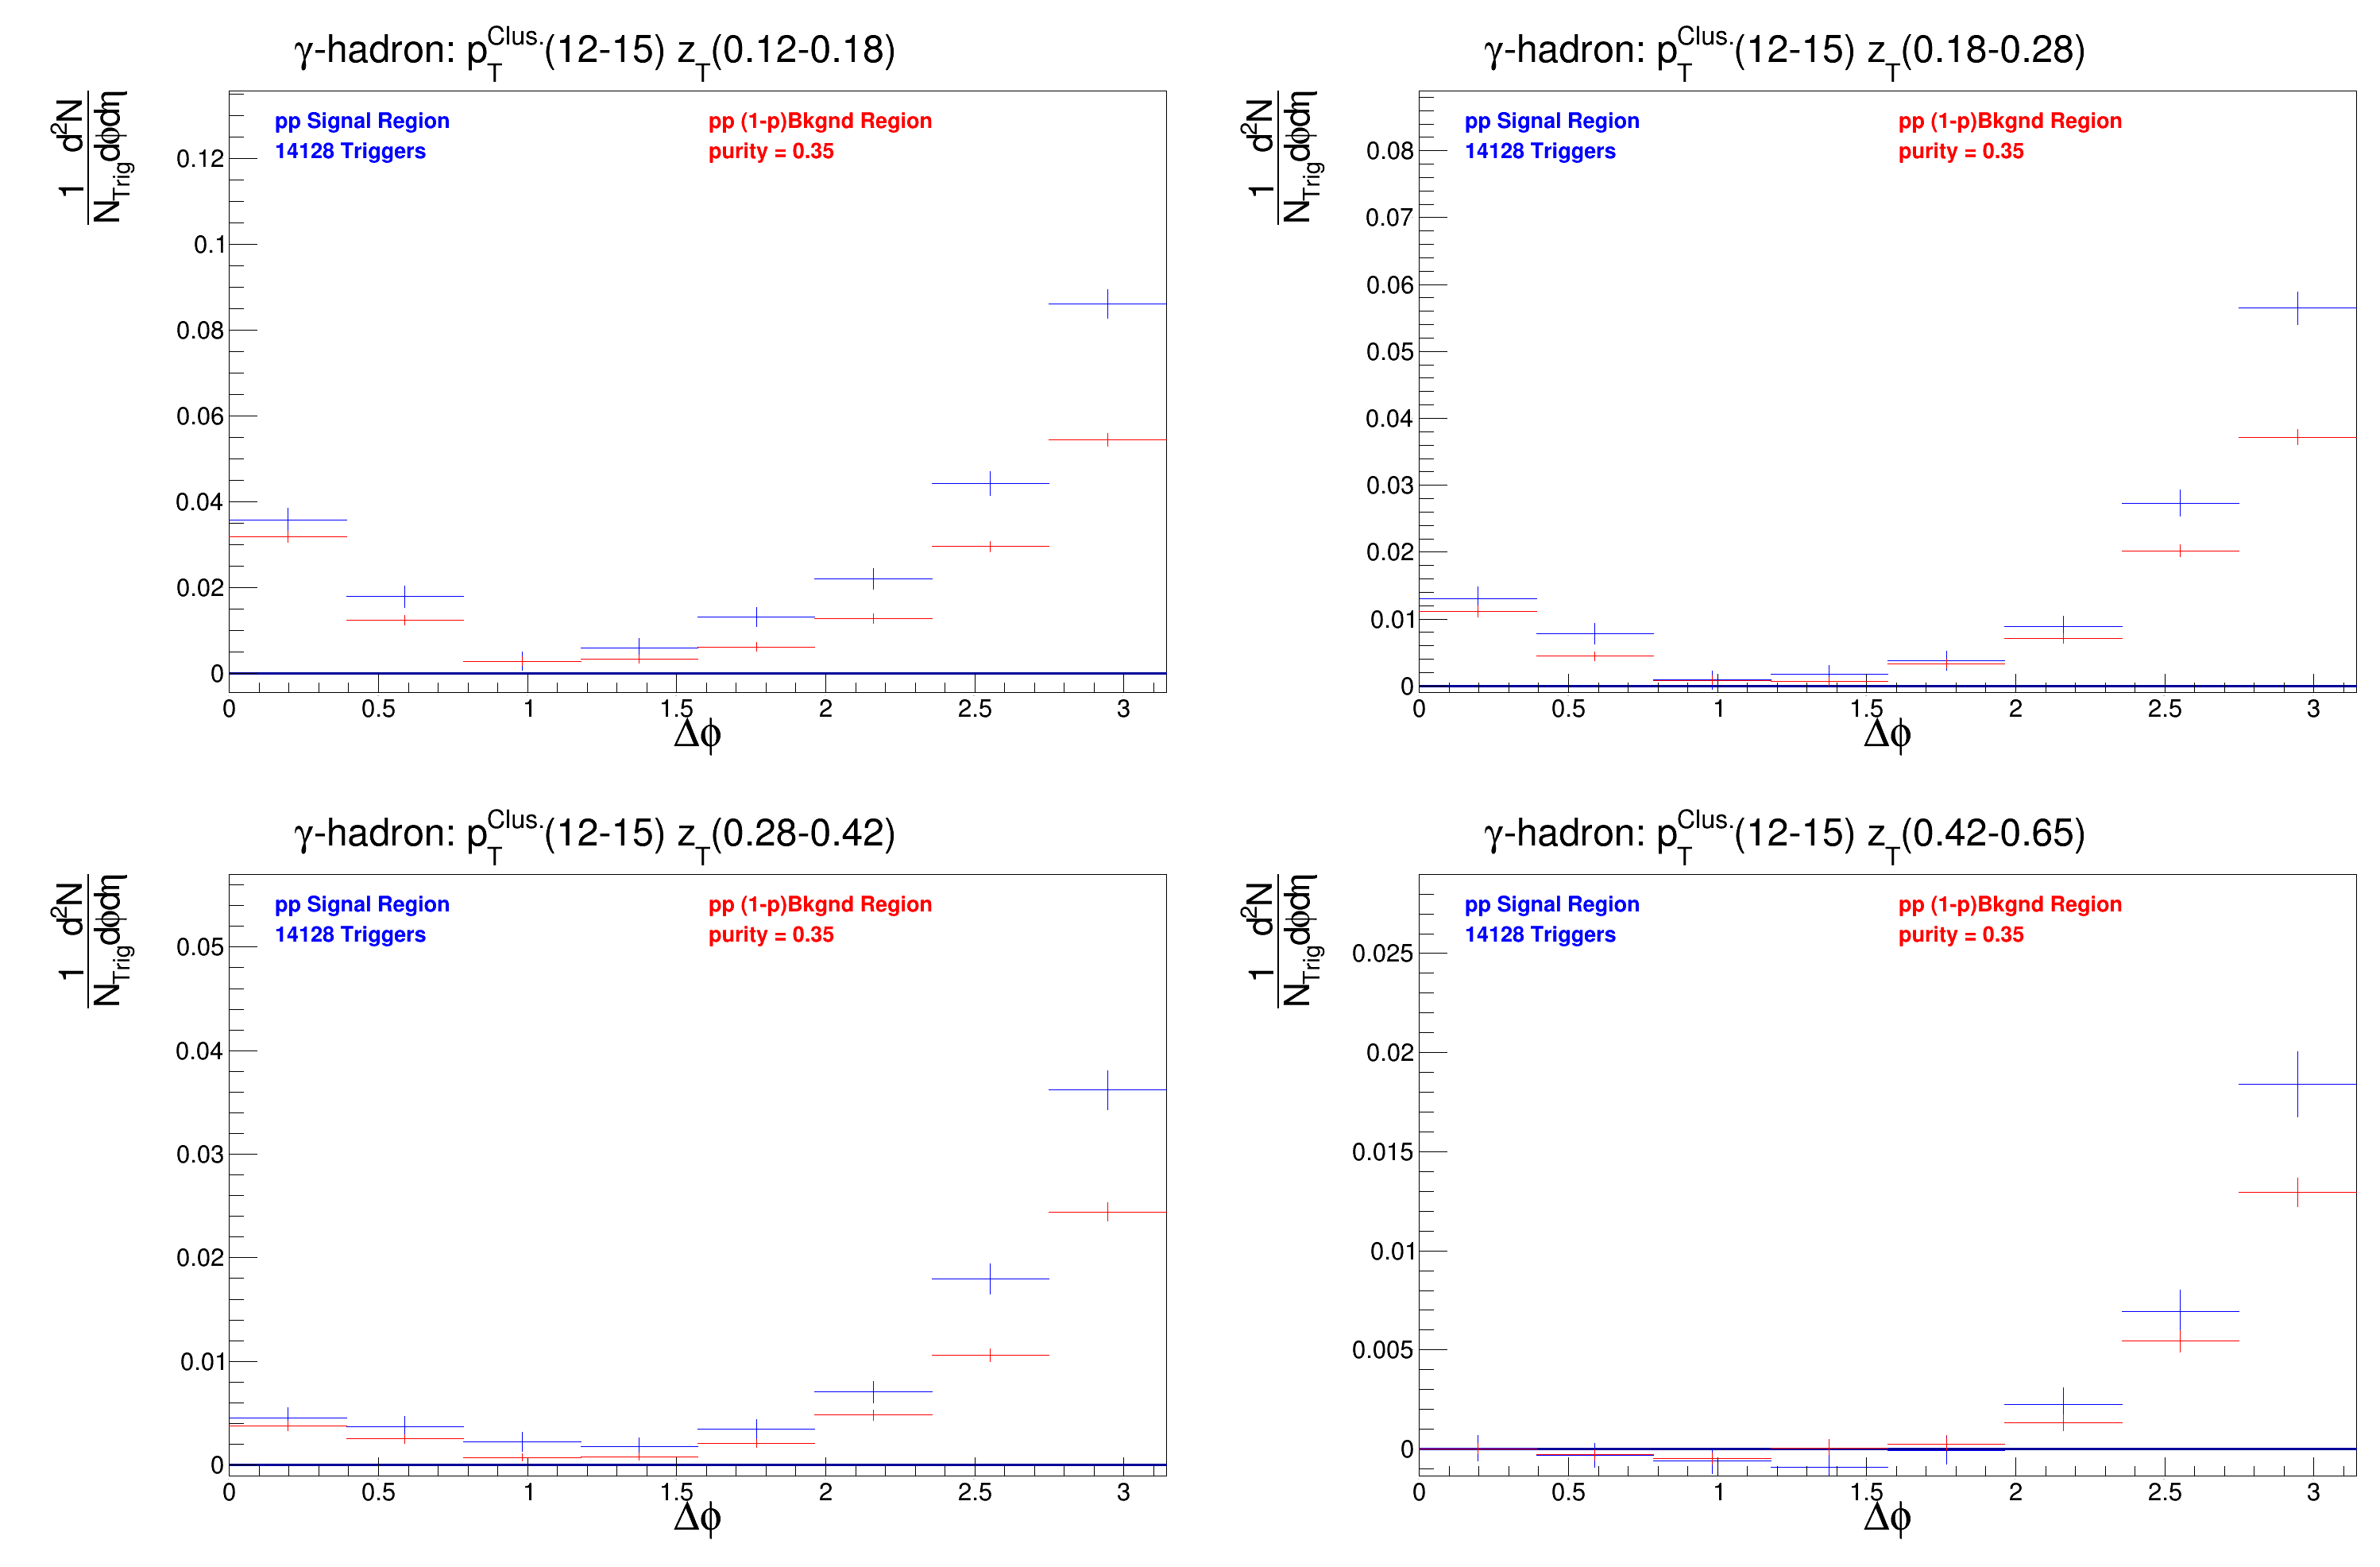

[<ROOT.TCanvas object ("canv0") at 0x72eecd0>,
 <ROOT.TCanvas object ("canv1") at 0x7423670>,
 <ROOT.TCanvas object ("canv2") at 0x744b3d0>]

Info in <TCanvas::Print>: pdf file pics/pp_correlations_Overlay.pdf has been created


In [38]:
Looping(MC_File,True,False,True)#Filename,DoZYAM,DoSub,!DoSys

In [39]:
E_Shower = [0.0,0.0,0.33,0.10,0.06,0.01,0.0]

# Fragmentation Function

In [40]:
def FF(File,prfx,DoSysB=False):
    zT_integral = []
    zT_point = []
    zT_error = []

    Sys_TypeA = []
    Sys_TypeB = []
    
    WantRatio = True
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    E_Shower = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    if (prfx == "pp"):
        E_Shower = [0.0,0.0,0.33,0.10,0.06,0.01,0.0]
    if (prfx == "13def"):
        E_Shower = [0.0,0.0,0.05,0.04,0.0,0.01,0.0]
        
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2

        for ztbin in range(7):
            izt = ztbin
            if (prfx == '18b10a'):
                #hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,False,False)#doZYAM,doSubtraction,dosys                                                                                                                                                                                                                                                                                                                                                                                                                                                      
                hsig = GetPhiProj(File,prfx,ptbin,ztbin,True,True,False)
            else:
                hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)#doZYAM,doSubtraction,dosys                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)
            Phi_bin_min = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi)
            #zT_point.append((zTbins[ztbin]+zTbins[ztbin+1])/2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            zT_width = zTbins[ztbin+1]-zTbins[ztbin]
            temp_int = hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi))

            #temp_int = hsig.Integral(hsig.GetXaxis().FindBin(math.pi/2),hsig.GetXaxis().FindBin(math.pi))                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            #print temp_int                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

            if (prfx == 'pp'):
                Sys_TypeA.append(math.sqrt(pp_LE_Error[izt]**2))
                Sys_TypeB.append(math.sqrt(pp_Eff_Error[izt]**2))
            elif (prfx == '13def'):
                Sys_TypeA.append(math.sqrt(pPb_LE_Error[izt]**2))
                Sys_TypeB.append(math.sqrt(pPb_Eff_Error[izt]**2))
            if (prfx == '18b10a'):
                Sys_TypeA.append(math.sqrt(MC_LE_Error[izt]**2 + MC_Eff_Error[izt]**2))
                Sys_TypeB.append(0)

            #errors                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
            zt_tmp_e = 0.0
            if not(DoSysB):
                for phibin in range(Phi_bin_min+1, Phi_bin_max):
                    zt_tmp_e += (hsig.GetBinError(phibin))**2
                zt_tmp_e = math.sqrt(zt_tmp_e)
                zt_tmp_e = zt_tmp_e*Corrections[ztbin]
                zt_tmp_e = zt_tmp_e*oneminFake[ztbin]
                if (WantRatio):
                    #zt_tmp_e = math.sqrt(zt_tmp_e**2+Sys_TypeA[ztbin]**2)/zT_width
                    zt_tmp_e = math.sqrt(zt_tmp_e**2)/zT_width
                else:
                    zt_tmp_e = math.sqrt(zt_tmp_e**2+Sys_TypeA[ztbin]**2 + (0.051*temp_int)**2 + (E_Shower[ztbin]*zT_width)**2)/zT_width
                #print "Stat. Error on FF for ",prfx," = ",zt_tmp_e
                

            else:
                if not(prfx=="18b10a"):
                    if (WantRatio):
                        Sys_TypeB[ztbin] = math.sqrt(Sys_TypeB[ztbin]**2)
                    else:
                        Sys_TypeB[ztbin] = math.sqrt(Sys_TypeB[ztbin]**2 + (0.25*temp_int)**2 )
                zt_tmp_e = Sys_TypeB[ztbin]/zT_width
                zt_tmp_e = zt_tmp_e*Corrections[ztbin]
                zt_tmp_e = zt_tmp_e*oneminFake[ztbin]
                #zt_tmp_e = math.sqrt(zt_tmp_e**2+E_Shower[ztbin])

            #print 'uncorrected integral = ',temp_int
            temp_int = temp_int/zT_width
            temp_int = temp_int*Corrections[ztbin]
            temp_int = temp_int*oneminFake[ztbin]
            zT_error.append(zt_tmp_e)
            zT_integral.append(temp_int)
        #print zT_error
    return zT_integral,zT_error
                                                                  

In [41]:
# File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
#RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
prfx2 = 'pp'
#FF(RootFile,"13def")
#FF(File2,prfx2)
FF(File2,prfx2)

([4.109162817729296,
  4.0512350686787535,
  2.417370437721355,
  0.7845308849423152,
  0.37383452952438895,
  0.07482176016064762,
  0.02551690182731429],
 [0.7023077717066715,
  0.40070262508992827,
  0.20603282413032556,
  0.10557314514431684,
  0.04951832931826512,
  0.023114212442483555,
  0.007124456610913645])

In [42]:
#np.geomspace(0.05,1,8)

In [105]:
pp_E_Shower = [0.33,0.10,0.06,0.01]
pPb_E_Shower = [0.05,0.04,0.005,0.01]
pp_Sys = []
pPb_Sys = []
for z in range (4):
    pp_Sys.append(math.sqrt(pp_E_Shower[z]**2 + (pp_LE_Error[2])**2))
    pPb_Sys.append(math.sqrt(pPb_E_Shower[z]**2 + (pPb_LE_Error[2])**2)) 

In [106]:
jet_5_10_x = [0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.425,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.925]
jet_5_10_y = [14.365,12.023,9.813,7.862,6.243,4.979,4.045,3.260,2.598,2.072,1.677,1.320,1.048,0.842,0.680,0.549,0.377]

jet_10_15_x = [0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.875,0.925]
jet_10_15_y = [23.185,17.108,12.583,9.358,6.987,5.213,3.956,2.233,1.637,1.304,1.007,0.774,0.597,0.454,0.370,0.284,0.219]

jet_5_10_y = np.asarray(jet_5_10_y)*(1.0/6)
jet_10_15_y = np.asarray(jet_10_15_y)*(1.0/6)

jet_5_10_x = np.asarray(jet_5_10_x)*(2.0/3.0)
jet_10_15_x = np.asarray(jet_10_15_x)*(2.0/3.0)

print len(jet_5_10_y)
print len(jet_5_10_x)
print len(jet_10_15_y)
print len(jet_10_15_x)

17
17
17
17


# Loop All FF

hi
[0.063353185, 0.097191855, 0.14910469, 0.228745595, 0.35092488499999996, 0.53836348, 0.82591817]
[0.013353184999999997, 0.020485485000000005, 0.03142735, 0.04821355499999999, 0.073965735, 0.11347286000000001, 0.17408183]
20
MC:  [2.950071635246888, 1.2902290031328303, 0.3720758100586398, 0.1733738581069523]
pp:  [2.7585, 0.8295, 0.4015, 0.0777]
pp Error:  [0.241, 0.11355, 0.05355, 0.01555]
pPb  [2.303, 0.9015, 0.28, 0.0489]
pPb Error:  [0.245, 0.1065, 0.043, 0.0155]


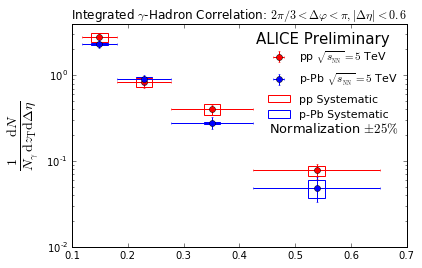

In [142]:
## MC_int, MC_error = FF(MC_File,'18b10a',False)
MC_int,MC_LE_error = FF(MC_File,'18b10a',True)
print "hi"
#print MC_error
zT_point = []
zT_width = []
pp_min = []
pp_max = []


pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)
for ztbin in range(NzT):
    zT_point.append((zTbins[ztbin]+ zTbins[ztbin+1])/2)
    zT_width.append((zTbins[ztbin+1]-zTbins[ztbin])/2)
    pp_max.append(pp_int[ztbin]*1.25)
    pp_min.append(pp_int[ztbin]*0.75)
    #MC_error[ztbin] = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)
print zT_point
print zT_width

Compare_Jets = False

file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")
#pp7_sys.SetLineColor(1)
#pp7_sys.Draw("sameE2")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
nbins = pp7.GetSize()-2
print nbins
pp7_data = []
pp7_x = []
pp7_error = []
pp7_width = []
pp7_Sys = []
#pp7.Scale(6.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
for i in range (2,nbins-1):
    #print i,pp7.GetBinCenter(i)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    pp7_data.append(pp7.GetBinContent(i))
    pp7_x.append(pp7.GetBinCenter(i))
    pp7_error.append(pp7.GetBinError(i))
    pp7_Sys.append(pp7_sys.GetBinError(i))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    pp7_width.append(pp7.GetXaxis().GetBinWidth(i)/2)
#print "width ",pp7_width                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
#print pp7_x                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

#Lambda                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
#pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
#pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

#GetBKGsubtracted(File2,prfx2,ptbin,ztbin,DoZYAM,DoSub,DoSys)

pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)

#pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
#pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


#pPb NN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
# pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
# pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

pPb_int, pPb_error = FF(pPb_File,'13def',False)
pPb_int_sys, pPb_error_sys = FF(pPb_File,'13def',True)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
pPb_int = pPb_int[2:6]
pPb_error = pPb_error[2:6]
pPb_int_sys =pPb_int_sys[2:6]
pPb_error_sys = pPb_error_sys[2:6]
pp_int = pp_int[2:6]
pp_error = pp_error[2:6]
pp_int_sys = pp_int_sys[2:6]
pp_error_sys =  pp_error_sys[2:6]
MC_int = MC_int[2:6]
#MC_error = MC_error[2:6]
MC_LE_error = MC_LE_error[2:6]
pp_min = pp_min[2:6]
pp_max = pp_max[2:6]

zT_point = zT_point[2:6]
zT_width = zT_width[2:6]
#MC_int, MC_error = FF(MC_File,'18b10a',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
#MC_int,MC_LE_error = FF(MC_File,'18b10a',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#MC_error = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


pp_int = [2.7585,0.8295,0.4015,0.0777]
pp_error = [0.241,0.11355,0.05355,0.01555]
pPb_int = [2.3030,0.9015,0.28,0.0489]
pPb_error = [0.245,0.1065,0.043,0.0155]

print "MC: ",MC_int
print "pp: ",pp_int
print "pp Error: ",pp_error
print "pPb ",pPb_int
print "pPb Error: ",pPb_error
#HARDCODED DUE TO VERY SLIGHTLY DIFFERENT TREATMENT OF UE in MC (NO SIGNAL/BACKGROUND AVERAGE), NEED TO IMPLEMENT FLAG                                                                                                                                                                                                                                                                                                                                                                                                                                                      
#MC_int = [11.310060491732425, 7.218237175683422, 3.3433128788925974, 1.493177381233851, 0.4219207415978905, 0.21746230788120627,0.14140750410259098]                                                                                                                                                                                                                                                                                                                                                                                                                       
#MC_int = [10.144789996230653, 7.015105856903631, 3.515205460316105, 1.3819702542411194, 0.34675022023361635, 0.22417399972941549]                                                                                                                                                                                                                                                                                                                                                                                                                                          
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
#Jets


if (Compare_Jets):
    jet1 = plt.errorbar(jet_5_10_x,jet_5_10_y,yerr=0,xerr=0.025,fmt='s',color='green',alpha=0.6,label=r'$p_T^{ch\ jet}$ 5-10GeV/c')
    jet2 = plt.errorbar(jet_10_15_x,jet_10_15_y,yerr=0,xerr=0.025,fmt='cs',alpha=0.6,label=r'$p_T^{ch\ jet}$ 10-15GeV/c')

#pPb
dx = 0.03
x = np.asarray(zT_point)
y = np.asarray(pPb_int)
ex = np.ones(x.shape) * dx
#ey = y*0.15    # e.g. a 15% uncertainty
ey = np.asarray(pPb_Sys)
pPb_bar = plt.bar(x, ey+ey, bottom=y-ey, width=ex, align='center',edgecolor="blue",color='white',)

#pp
dxp = 0.03
xp = np.asarray(zT_point)
yp = np.asarray(pp_int)
exp = np.ones(xp.shape) * dxp
#ey = y*0.15    # e.g. a 15% uncertainty
eyp = np.asarray(pp_Sys)
pp_bar = plt.bar(xp, eyp+eyp, bottom=yp-eyp, width=exp, align='center',edgecolor="red",color='white',)
    
pp_plot = plt.errorbar(zT_point, pp_int,xerr=zT_width,yerr=pp_error,linewidth=1,fmt='ro',capsize=1,label='pp')
#plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue',label="pp Systematic")
#plt.fill_between(zT_point, pp_min, pp_max,interpolate=True, alpha=0.5,facecolor='blue')
#plt.errorbar(zT_point, pp_int, yerr=pp_error, fmt='k.',capsize=2)

#plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
#plt.fill_betweenx(pp_int,np.asarray(zT_point)-np.asarray(zT_width),np.asarray(zT_point)+np.asarray(zT_width), alpha=0.5)                                                                                                                                                                                                                                                                                                                                                                                                                                                   

pPb_plot = plt.errorbar(zT_point, pPb_int,xerr=zT_width,yerr=pPb_error,linewidth=1, fmt='bo',capsize=1,label='p-Pb')
#plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
#plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='k.',capsize=2)

#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red',label="p-Pb Systematic")


#Removed for preliminary
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.03,fmt='g.-',capsize=2)
#plt.fill_between(pp7_x,np.asarray(pp7_data)-np.asarray(pp7_Sys),np.asarray(pp7_data)+np.asarray(pp7_Sys),interpolate=False, alpha=0.5,facecolor='green')
#plt.fill_between(zT_point, np.asarray(MC_int)-np.asarray(MC_error), np.asarray(MC_int)+np.asarray(MC_error),interpolate=False, alpha=0.5,facecolor='cyan')                                                                                                                                                                                                                                                                                                                                                                                                                 


#plt.plot(zT_point,MC_int,'co')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
plt.yscale('log')
#plt.xscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
#plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
##plt.xlabel(r"$z_{\mathrm{T}} = \frac{p_\mathrm{T}^{\mathrm{h}}}{p_\mathrm{T}^\gamma},$ $\frac{2}{3} \ \frac{p_\mathrm{T}^{\mathrm{h}}}{p_\mathrm{T}^{\mathrm{ch \ jet}}} $",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=4)
# plt.figtext(0.65,0.751,"pPb $\sigma_{long}$ Data",color='Red', fontsize=15)
# plt.figtext(0.67,0.7,"pp $\sigma_{long}$ Data",color='Blue', fontsize=15)
#plt.figtext(0.65,0.751,"pPb Data",color='Red', fontsize=15)
#plt.figtext(0.65,0.7,"pp Data",color='Blue', fontsize=15)



#plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp","p-Pb",r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$'],frameon=False,numpoints=1,title='',prop={'size':12})
plt.legend([pp_plot,pPb_plot,pp_bar,pPb_bar],["pp $\sqrt{s_{\mathrm{_{NN}}}} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","pp Systematic","p-Pb Systematic"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':11})
P_x = [0.1]
P_One = [1]
P_E = [0.25]
#plt.errorbar[P_x,P_One,yerr=P_E,linewidth=1]

#plt.figtext(0.65,0.57,"$\sigma_{purity}$",color="Black",fontsize=20)
plt.figtext(0.58,0.52,"Normalization $\pm 25\%$",color='Black', fontsize=13)
#plt.figtext(0.55,0.2,"Jet Normalization 1/6",color='Black', fontsize=12)
#plt.figtext(0.55,0.15,"$\mathrm{\gamma}$-h Normalization $\pm 25\%$",color='Black', fontsize=12)
plt.figtext(0.55,0.83,"ALICE Preliminary",color='Black', fontsize=15)



#plt.figtext(0.65,0.802,"pythia $\gamma$-j pp",color='Cyan', fontsize=15)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
#plt.figure.set_size_inches(18.5, 10.5)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
#plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.gcf()
#plt.savefig("pics/Jet_FFunction.pdf", bbox_inches='tight')
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()


## Compare Shower Shape FF

hi
[1.146681805187267, 0.6439242845230021, 0.22674447069372025, 0.07042240706903169, 0.06608184284478098, 0.04687816977299429, 0.07465107899280378]
[0.063353185, 0.097191855, 0.14910469, 0.228745595, 0.35092488499999996, 0.53836348, 0.82591817]
[0.013353184999999997, 0.020485485000000005, 0.03142735, 0.04821355499999999, 0.073965735, 0.11347286000000001, 0.17408183]
20
MC:  [2.950071635246888, 1.2902290031328303, 0.3720758100586398, 0.1733738581069523]
pp:  [2.417370437721355, 0.7845308849423152, 0.37383452952438895, 0.07482176016064762]
pPb:  [2.2810606279164958, 0.890078893981755, 0.28394680215393536, 0.05347379767474394]


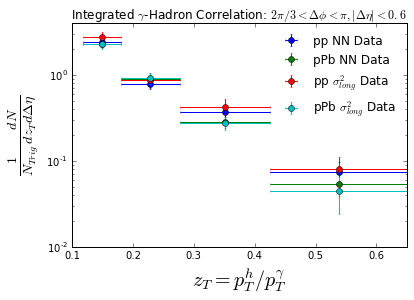

In [104]:
MC_int, MC_error = FF(MC_File,'18b10a',False)
MC_int,MC_LE_error = FF(MC_File,'18b10a',True)
print "hi"
print MC_error
zT_point = []
zT_width = []
pp_min = []
pp_max = []
pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)
for ztbin in range(NzT):
    zT_point.append((zTbins[ztbin]+ zTbins[ztbin+1])/2)
    zT_width.append((zTbins[ztbin+1]-zTbins[ztbin])/2)
    pp_max.append(pp_int[ztbin]*1.25)
    pp_min.append(pp_int[ztbin]*0.75)
    #MC_error[ztbin] = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)
print zT_point
print zT_width


file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")
#pp7_sys.SetLineColor(1)
#pp7_sys.Draw("sameE2")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
nbins = pp7.GetSize()-2
print nbins
pp7_data = []
pp7_x = []
pp7_error = []
pp7_width = []
pp7_Sys = []
#pp7.Scale(6.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
for i in range (2,nbins-1):
    #print i,pp7.GetBinCenter(i)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    pp7_data.append(pp7.GetBinContent(i))
    pp7_x.append(pp7.GetBinCenter(i))
    pp7_error.append(pp7.GetBinError(i))
    pp7_Sys.append(pp7_sys.GetBinError(i))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    pp7_width.append(pp7.GetXaxis().GetBinWidth(i)/2)

pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

pPb_int, pPb_error = FF(pPb_File,'13def',False)
pPb_int_sys, pPb_error_sys = FF(pPb_File,'13def',True)
                                                                         
pPb_int = pPb_int[2:6]
pPb_error = pPb_error[2:6]
pPb_int_sys =pPb_int_sys[2:6]
pPb_error_sys = pPb_error_sys[2:6]
pp_int = pp_int[2:6]
pp_error = pp_error[2:6]
pp_int_sys = pp_int_sys[2:6]
pp_error_sys =  pp_error_sys[2:6]
MC_int = MC_int[2:6]
MC_error = MC_error[2:6]
MC_LE_error = MC_LE_error[2:6]
pp_min = pp_min[2:6]
pp_max = pp_max[2:6]

zT_point = zT_point[2:6]
zT_width = zT_width[2:6]
#MC_int, MC_error = FF(MC_File,'18b10a',False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
#MC_int,MC_LE_error = FF(MC_File,'18b10a',True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#MC_error = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

print "MC: ",MC_int
print "pp: ",pp_int
print "pPb: ",pPb_int


L0_pp =  [2.7427184781952936, 0.8753815097422311, 0.429033119868042, 0.08060577353743517]
L0_pp_E = [0.45316117125988203, 0.16957729598601515, 0.0889978962352422, 0.03006821690151471]
L0_pPb = [2.3260559363976294, 0.9310683709971448, 0.2758857851603638, 0.04437041594268927]
L0_pPb_E = [0.30593559272871085, 0.13619726138047716, 0.050403919898293285, 0.020346281808276027]

                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.errorbar(zT_point, pp_int,xerr=zT_width,yerr=pp_error,linewidth=1,fmt='o',capsize=1,label='pp NN Data')
#plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue',label="pp Systematic")

plt.errorbar(zT_point, pPb_int,xerr=zT_width,yerr=pPb_error,linewidth=1, fmt='o',capsize=1,label='pPb NN Data')
#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red',label="p-Pb Systematic")

plt.errorbar(zT_point, L0_pp,xerr=zT_width,yerr=L0_pp_E,linewidth=1, fmt='o',capsize=1,label='pp $\sigma_{long}^2$ Data')

plt.errorbar(zT_point, L0_pPb,xerr=zT_width,yerr=L0_pPb_E,linewidth=1, fmt='o',capsize=1,label='pPb $\sigma_{long}^2$ Data')


#Removed for preliminary
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.03,fmt='g.-',capsize=2)
#plt.fill_between(pp7_x,np.asarray(pp7_data)-np.asarray(pp7_Sys),np.asarray(pp7_data)+np.asarray(pp7_Sys),interpolate=False, alpha=0.5,facecolor='green')
#plt.fill_between(zT_point, np.asarray(MC_int)-np.asarray(MC_error), np.asarray(MC_int)+np.asarray(MC_error),interpolate=False, alpha=0.5,facecolor='cyan')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T} d\Delta\eta}$",fontsize=20)
plt.xlabel("${z_T} = p_T^{h}/p_T^\gamma$",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.65)
plt.ylim(ymin = 0.01,ymax=4)




plt.legend(frameon=False,numpoints=1,prop={'size':12})

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
plt.title('Integrated $\gamma$-Hadron Correlation: $2\pi/3 < \Delta\phi < \pi, |\Delta\eta| < 0.6$ ')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.gcf()
plt.savefig("pics/Shower_FFunction.pdf", bbox_inches='tight')
plt.show()



## Fit pPb

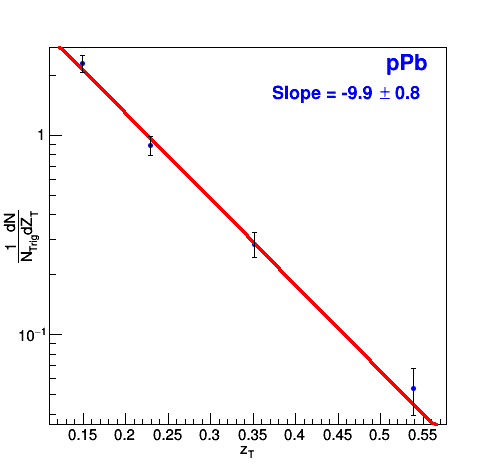

 FCN=1.43768 FROM MIGRAD    STATUS=CONVERGED      41 CALLS          42 TOTAL
                     EDM=1.64798e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.22792e+00   1.80519e-01   4.88773e-05  -1.58378e-02
   2  Slope       -9.89840e+00   7.08487e-01   1.90452e-04  -1.64831e-03


Info in <TCanvas::Print>: pdf file pics/pPb_FF_Fit.pdf has been created


In [46]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()#(6,np.asarray(zT_point),np.asarray(pPb_int),np.asarray(z_error),np.asarray(pPb_error)))
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i
    pPb_Fit_Plot.SetPoint(i,zT_point[izt],pPb_int[izt])
    pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")

pPb_canv = ROOT.TCanvas("pPbcan","pPbcan",500,500)
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
latex.DrawLatex(0.78,0.85, "#color[4]{pPb}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9.9 #pm 0.8}")
ROOT.gPad.SetLogy()
pPb_canv.Update()
pPb_canv.Draw()
pPb_canv.SaveAs("pics/pPb_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

## Fit pp

[0.14910469, 0.228745595, 0.35092488499999996, 0.53836348]


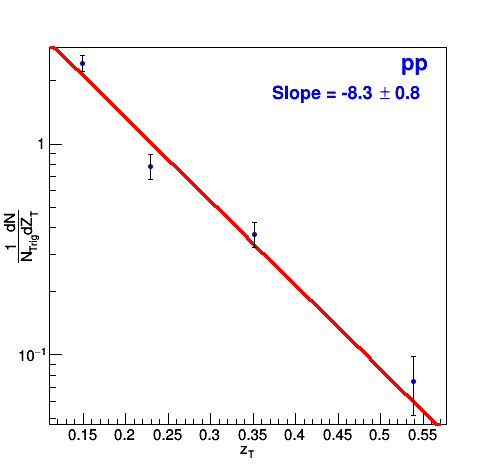

 FCN=8.21671 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=2.08032e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.11788e+00   1.86443e-01   9.32826e-05  -4.15616e-04
   2  Slope       -9.15978e+00   7.77699e-01   3.88969e-04  -3.53896e-04


Info in <TCanvas::Print>: pdf file pics/pp_FF_Fit.pdf has been created


In [47]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.DrawLatex(0.81,0.85, "#color[4]{pp}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -8.3 #pm 0.8}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

# Fit Jets

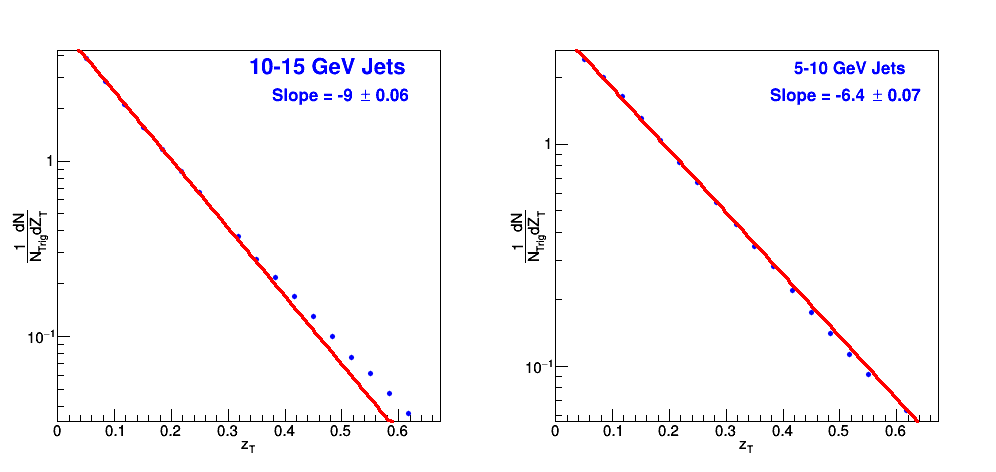


****************************************
Minimizer is Minuit / Migrad
Chi2                      =   0.00499475
NDf                       =           15
Edm                       =  1.97883e-09
NCalls                    =           43
Constant                  =      1.80579   +/-   0.0064226   
Slope                     =     -8.95128   +/-   0.0613317   

****************************************
Minimizer is Minuit / Migrad
Chi2                      =   0.00633029
NDf                       =           15
Edm                       =  2.32807e-09
NCalls                    =           39
Constant                  =      1.22412   +/-   0.00888129  
Slope                     =     -6.44098   +/-   0.0651429   


Info in <TCanvas::Print>: pdf file pics/Jet_FF_Fit.pdf has been created


In [48]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()
pPb_Fit_Plot2 = ROOT.TGraphErrors()
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (17):
    izt = i
    pPb_Fit_Plot.SetPoint(i,jet_10_15_x[i],jet_10_15_y[i])
    pPb_Fit_Plot2.SetPoint(i,jet_5_10_x[i],jet_5_10_y[i])
    #pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")
pPb_Fit_Plot2.Fit("expo")

pPb_canv2 = ROOT.TCanvas("pPbcan2","pPbcan2",1000,500)
pPb_canv2.Divide(2,1)
pPb_canv2.cd(1)
ROOT.gPad.SetLogy()
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
#pPb_Fit_Plot.GetXaxis().SetRangeUser(0,1)
#pPb_Fit_Plot.GetYaxis().SetRangeUser(0.01,20)
latex.DrawLatex(0.5,0.85, "#color[4]{10-15 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9 #pm 0.06}")



pPb_canv2.cd(2)
pPb_Fit_Plot2.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot2.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot2.GetXaxis().CenterTitle(1)
pPb_Fit_Plot2.GetYaxis().CenterTitle(1)
pPb_Fit_Plot2.Draw("AP")
latex.DrawLatex(0.6,0.85, "#color[4]{5-10 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -6.4 #pm 0.07}")



ROOT.gPad.SetLogy()
pPb_canv2.Update()
pPb_canv2.Draw()
pPb_canv2.SaveAs("pics/Jet_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

# Divide FF

[0.1285, 0.199, 0.144, 0.293]
[0.14910469, 0.228745595, 0.35092488499999996, 0.53836348]


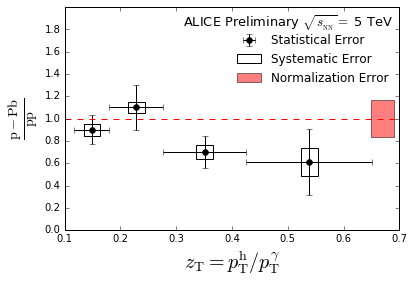

In [140]:
#pPb/pp                                                                                                                                                                                                         
Ratio = []
Ratio_Error = []
whole = [0.65,0.69]
zT_point2 = []
zT_width2 = []

#Obtained with deta < 0.6, LE, and Uncorrected Purity
E_Shower_Ratio = [0.05,0.04,0.055,0.115]
Ratio_Shower_Average = [0.9,1.10,0.7,0.61]
Ratio_Shower_Stat = [0.1285,0.199,0.144,0.293]
Ratio_Sys = []
UE_Rel = [0.0179,0.0214,0.0269,0.0488]
UE_Error = []

DoShowerAverage=True

#E_Shower_pp = [0.33,0.10,0.06,0.01]
#E_Shower_pPb = [0.05,0.04,0.0,0.01]
xfill = [0.65,0.7]
for ztbin in range (4):
    #pp_error[ztbin] = math.sqrt(pp_error[ztbin]**2 - E_Shower_pp[ztbin]**2)
    #pPb_error[ztbin] = math.sqrt(pPb_error[ztbin]**2 - E_Shower_pPb[ztbin]**2)
    #Ratio.append(pPb_int[ztbin]/MC_int[ztbin])                                                                                                                                                                 
    #Ratio_Error.append(math.sqrt((MC_error[ztbin]/MC_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin])                                                                                        
    Ratio_Sys.append(math.sqrt(UE_Rel[ztbin]**2 + E_Shower_Ratio[ztbin]**2))
    if (DoShowerAverage):
        #Ratio_Error.append(math.sqrt( (Ratio_Shower_Stat[ztbin]**2)+(E_Shower_Ratio[ztbin])**2))
        Ratio_Error.append(math.sqrt( (Ratio_Shower_Stat[ztbin]**2)))
        Ratio = Ratio_Shower_Average
    else:   
        Ratio.append(pPb_int[ztbin]/pp_int[ztbin])
        Ratio_Error.append(math.sqrt((pp_error[ztbin]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] + E_Shower_Ratio[ztbin]**2)
    UE_Error.append(UE_Rel[ztbin]*Ratio_Shower_Average[ztbin])
    
    #print (Ratio_Error[ztbin]/Ratio[ztbin])*100
    zT_point2.append(zT_point[ztbin])
    zT_width2.append(zT_width[ztbin])
#     print "UE Error", "%1.2f"%(math.sqrt((pp_LE_Error[izt]/pp_int[ztbin])**2 + (pPb_LE_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)                                                                   
#     print "P Stat. Error", "%1.2f"%(math.sqrt((pp_P_stat_Error[izt]/pp_int[ztbin])**2 + (pPb_P_stat_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)                                                      
#     print "Statistical Error","%1.2f"%(math.sqrt((pp_error[izt]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)                                                                 
#     print Ratio[ztbin]                                                                                                                                                                                        
print Ratio_Error
#plt.errorbar(zT_point2, Ratio, yerr=Ratio_Error,xerr=zT_width2, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2,label = "Uncorrelated Uncertainty")
#plt.errorbar(zT_point, Ratio_L, yerr= Ratio_Error_L, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)                                                                                                                 
#plt.errorbar(zT_point, Ratio_E, yerr= Ratio_Error_E, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)  

dxr = 0.03
xr = np.asarray(zT_point2)
yr = np.asarray(Ratio)
exr = np.ones(x.shape) * dx
#ey = y*0.15    # e.g. a 15% uncertainty
eyr = np.asarray(Ratio_Sys)
bar = plt.bar(xr, eyr+eyr, bottom=yr-eyr, width=exr, align='center',edgecolor="black",color='white',)

E_band = plt.fill_between(whole, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')
if (DoShowerAverage):
    R_points = plt.errorbar(zT_point2, Ratio_Shower_Average, yerr=Ratio_Error,xerr=zT_width2, fmt='ko',capsize=3, ms=6,lw=1)    
else:
    R_points = plt.errorbar(zT_point2, Ratio, yerr=Ratio_Error,xerr=zT_width2, fmt='ko',capsize=3, ms=6,lw=1)
print zT_point2
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
#pol0 = np.polyfit(zT_point2, Ratio, 0, full = True)
#pol1 = np.polyfit(zT_point2,Ratio,1, full = True)
#print pol0
#print pol1
plt.yticks(np.arange(-0, 2, step=0.2))
#plt.xscale('log')
plt.xlim(xmin = 0.1,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')
#plt.figtext(0.14,0.83,"ALICE Preliminary 5 TeV",color='Black', fontsize=14)
#plt.figtext(0.6,0.71,"$\sigma_{P_{stat.}}$",color='Red', fontsize=25)
#plt.figtext(0.6,0.71,"ZYAM",color='Black', fontsize=15)                                                                                                                                                        
#plt.figtext(0.6,0.69,"pPb/pp $EMax$ ",color='Red', fontsize=15)                                                                                                                                                


#plt.legend(frameon=False,numpoints=1,prop={'size':11})
plt.legend([R_points,bar,E_band],["Statistical Error","Systematic Error","Normalization Error"],frameon=False,numpoints=1,title=' ',prop={'size':12})
#plt.title('Ratio of Integrated $\gamma$-Hadron Correlation: p-Pb/pp ',fontsize=13.5)
plt.figtext(0.4,0.83,"ALICE Preliminary $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=13)

plt.gcf()
plt.savefig("pics/NN_pp_FFunction.pdf", bbox_inches='tight')
plt.show()

# Fit Ratio

[0.14910469, 0.228745595, 0.35092488499999996, 0.53836348]


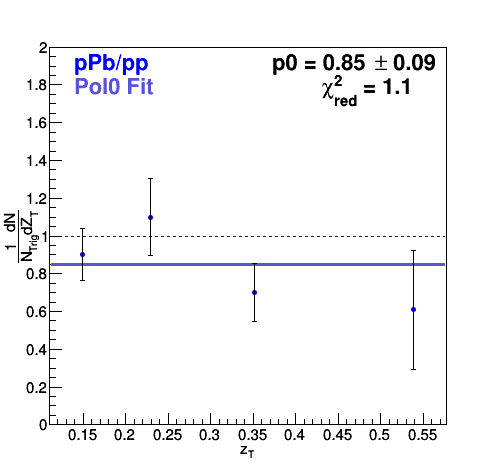


****************************************
Minimizer is Linear
Chi2                      =      3.17675
NDf                       =            3
p0                        =     0.849709   +/-   0.0880287   


Info in <TCanvas::Print>: pdf file pics/Ratio_Fit_0.pdf has been created


In [50]:
Ratio_Plot = ROOT.TGraphErrors()

deg = 0

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    Ratio_Plot.SetPoint(i,zT_point[izt],Ratio[izt])
    Ratio_Plot.SetPointError(i,0,Ratio_Error[izt])
Ratio_Plot.Fit("pol%i"%(deg))
Ratio_Plot.GetFunction("pol%i"%(deg)).SetLineColor(9);

Ratio_canv = ROOT.TCanvas("rcan","rcan",500,500)
Ratio_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
Ratio_Plot.GetXaxis().SetTitle("z_{T}")
Ratio_Plot.GetXaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().SetRangeUser(0,2)
Ratio_Plot.Draw("AP")
latex.DrawLatex(0.15,0.85, "#color[4]{pPb/pp}")
latex.DrawLatex(0.15,0.80, "#color[9]{Pol%i Fit}"%(deg))
if (deg == 1):
    latex.DrawLatex(0.65,0.75, "#chi^{2}_{red} = 0.8")
    latex.DrawLatex(0.6,0.85,"p0 = 1.1 #pm 0.2")
    latex.DrawLatex(0.6,0.80,"p1 = -1.0 #pm 0.7")
elif (deg ==0):
    latex.DrawLatex(0.65,0.8, "#chi^{2}_{red} = 1.1")
    latex.DrawLatex(0.55,0.85,"p0 = 0.85 #pm 0.09")

zero_line = ROOT.TLine(0.122,1,0.575,1)
zero_line.SetLineColorAlpha(1, 0.9)
zero_line.SetLineWidth(1)
zero_line.SetLineStyle(2)
SetOwnership(zero_line, 0)
zero_line.Draw("same")

latex.SetTextSize(0.04)
#ROOT.gPad.SetLogy()
Ratio_canv.Update()
Ratio_canv.Draw()
Ratio_canv.SaveAs("pics/Ratio_Fit_%i.pdf"%(deg))
pp_Fit_Plot = ROOT.TGraphErrors()

# Overlay pPb and pp

In [51]:
#prefix ='13def'

In [52]:
def MC_DATA(Region):

        File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
        prfx1 = '13def'

        File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
        prfx2 = 'pp'

        File3 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
        prfx3 = "18b10a"           
    
        Uncorr = False
        DoZyam = True
        DoSub = False
        DoSys = True
        
        
        
        
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        hstack = []
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        
        if (Region=="regions"):
            #canvases.Divide(4,3)
            canvases.Divide(2,2)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(0,4):
            
                
            if (Region=="regions"):              
            #grab
                hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.2f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin+2],zTbins[ztbin+3])))
                
                hsig3 = GetPhiProj(MC_File,prfx3,ptbin,ztbin,True,True,False) #[DNN],[Subtraction Bool][DoSys]
                hsig3.SetFillColor(7)
                hsig1,htemp,NTrig1 = GetBKGsubtracted(pPb_File,prfx1,ptbin,ztbin,True,DoSub,False)#doZYAM,doSubtraction,dosys 
                hsig1_sys,htemp1,NTrigtemp = GetBKGsubtracted(pPb_File,prfx1,ptbin,ztbin,True,DoSub,False)
                hsig1.SetMarkerColor(2)
                hsig1.SetLineColor(2)
                hsig1_sys.SetLineColor(2)
                
                hsig2,htemp,NTrig2 = GetBKGsubtracted(pp_File,prfx2,ptbin,ztbin,True,DoSub,False)#doZYAM,doSubtraction,dosys 
                hsig2_sys,htemp2,NTrigtemp = GetBKGsubtracted(pp_File,prfx2,ptbin,ztbin,True,DoSub,False)
                hsig2_sys.SetLineColor(4)
                hsig2.SetMarkerColor(4)
                hsig2.SetLineColor(4)
                
                ymax = 1.2*max(hsig3.GetMaximum(),hsig2.GetMaximum())
                ymin = -1.4*abs(min(hsig3.GetMinimum(),hsig2.GetMinimum()))
                hsig1.GetYaxis().SetRangeUser(ymin,ymax)
                hsig2.GetYaxis().SetRangeUser(ymin,ymax)    
                #canvases.cd(ztbin*2+1)
                
                canvases.cd(ztbin+1)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                #hstack[ztbin].Add(hsig3,"E3")
                hstack[ztbin].Add(hsig1)
                hstack[ztbin].Add(hsig2)
                hstack[ztbin].Draw("nostack")
                hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
                hstack[ztbin].GetYaxis().SetTitleSize(0.05)
                hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
                hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
                hstack[ztbin].GetXaxis().CenterTitle(1)
                hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
                hstack[ztbin].GetXaxis().SetTitleSize(0.06)
                #hstack.Clear()
                Sig_ZYAM= ZYAM_Line(hsig2) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(File2, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                #hsig1_sys.Draw("same")
                #hsig1.Draw("same")  
                #DrawLabel2(True)
                
                latex = TLatex()
                latex.SetNDC()
                latex.SetTextSize(0.03)
                latex.DrawLatex(0.2,0.85, "#color[2]{pPb+Pbp UE-Subtracted}")
                latex.DrawLatex(0.2,0.80, "#color[4]{pp UE-Subtracted}")
                #latex.DrawLatex(0.2,0.75, "#color[7]{pp MC: g-jet}")
                
    
            if (Region=="inclusive"):
                    hsig1 = GetPhiProj(RootFile,ptbin,ztbin,"inclusive",False,False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig1.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    #hsig1.Draw()  
                    DrawLabel2("inclusive")                  
                
            if (Region=="regions"):
                #hsig2_sys.SetFillColor(19)
                #hsig2_sys.Draw("Same")
                #hsig2.Draw("same")
                #DrawLabel2(False)
                hsig3.SetLineColor(3)
                #hsig3.Draw("same")
            

            
                
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/pp_pPb_UE.pdf")
            else:
                canvases.SaveAs("pics/pp_pPb_MC_Full_Sub.pdf")
        return canvases
#myText(.2,.2,"hello_%i"%number,1)

0.179535593013
0.121544251587
0.0609910788129
0.0242142375171


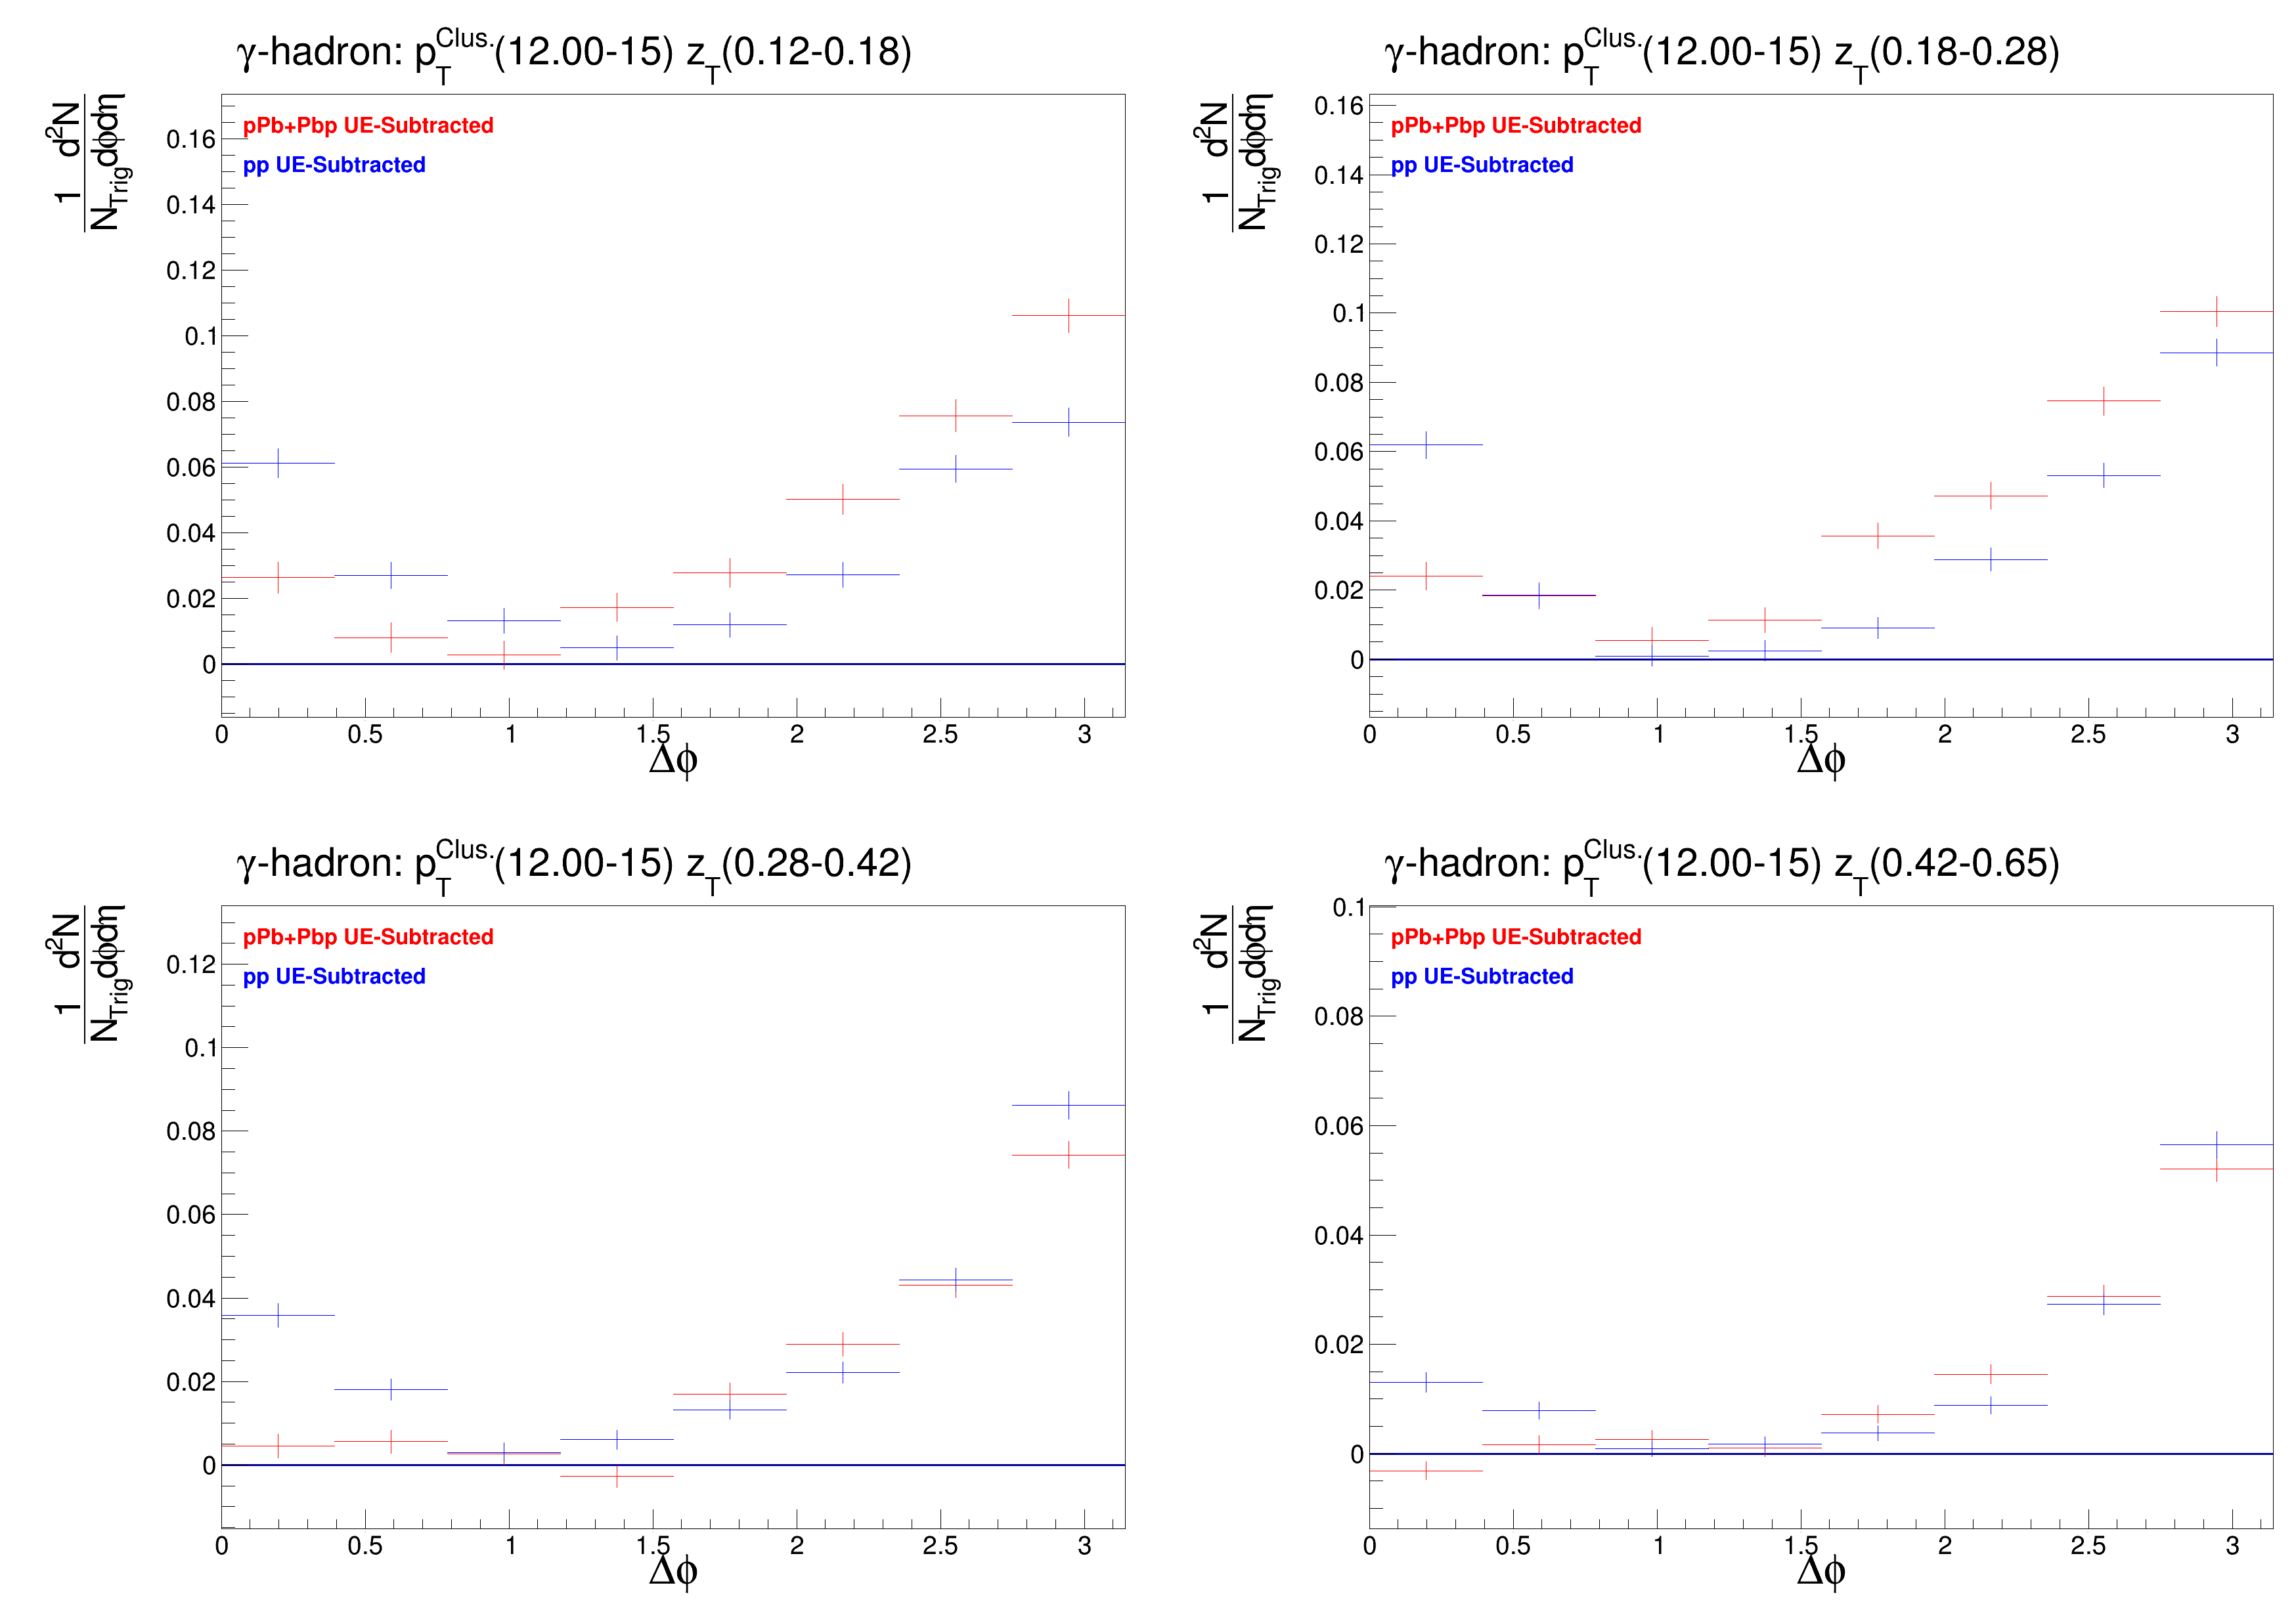

<ROOT.TCanvas object ("Canv_Side_Side_2") at 0x76956e0>

Info in <TCanvas::Print>: pdf file pics/pp_pPb_MC_Full_Sub.pdf has been created


In [53]:
MC_DATA("regions")

# Compare Gustavo

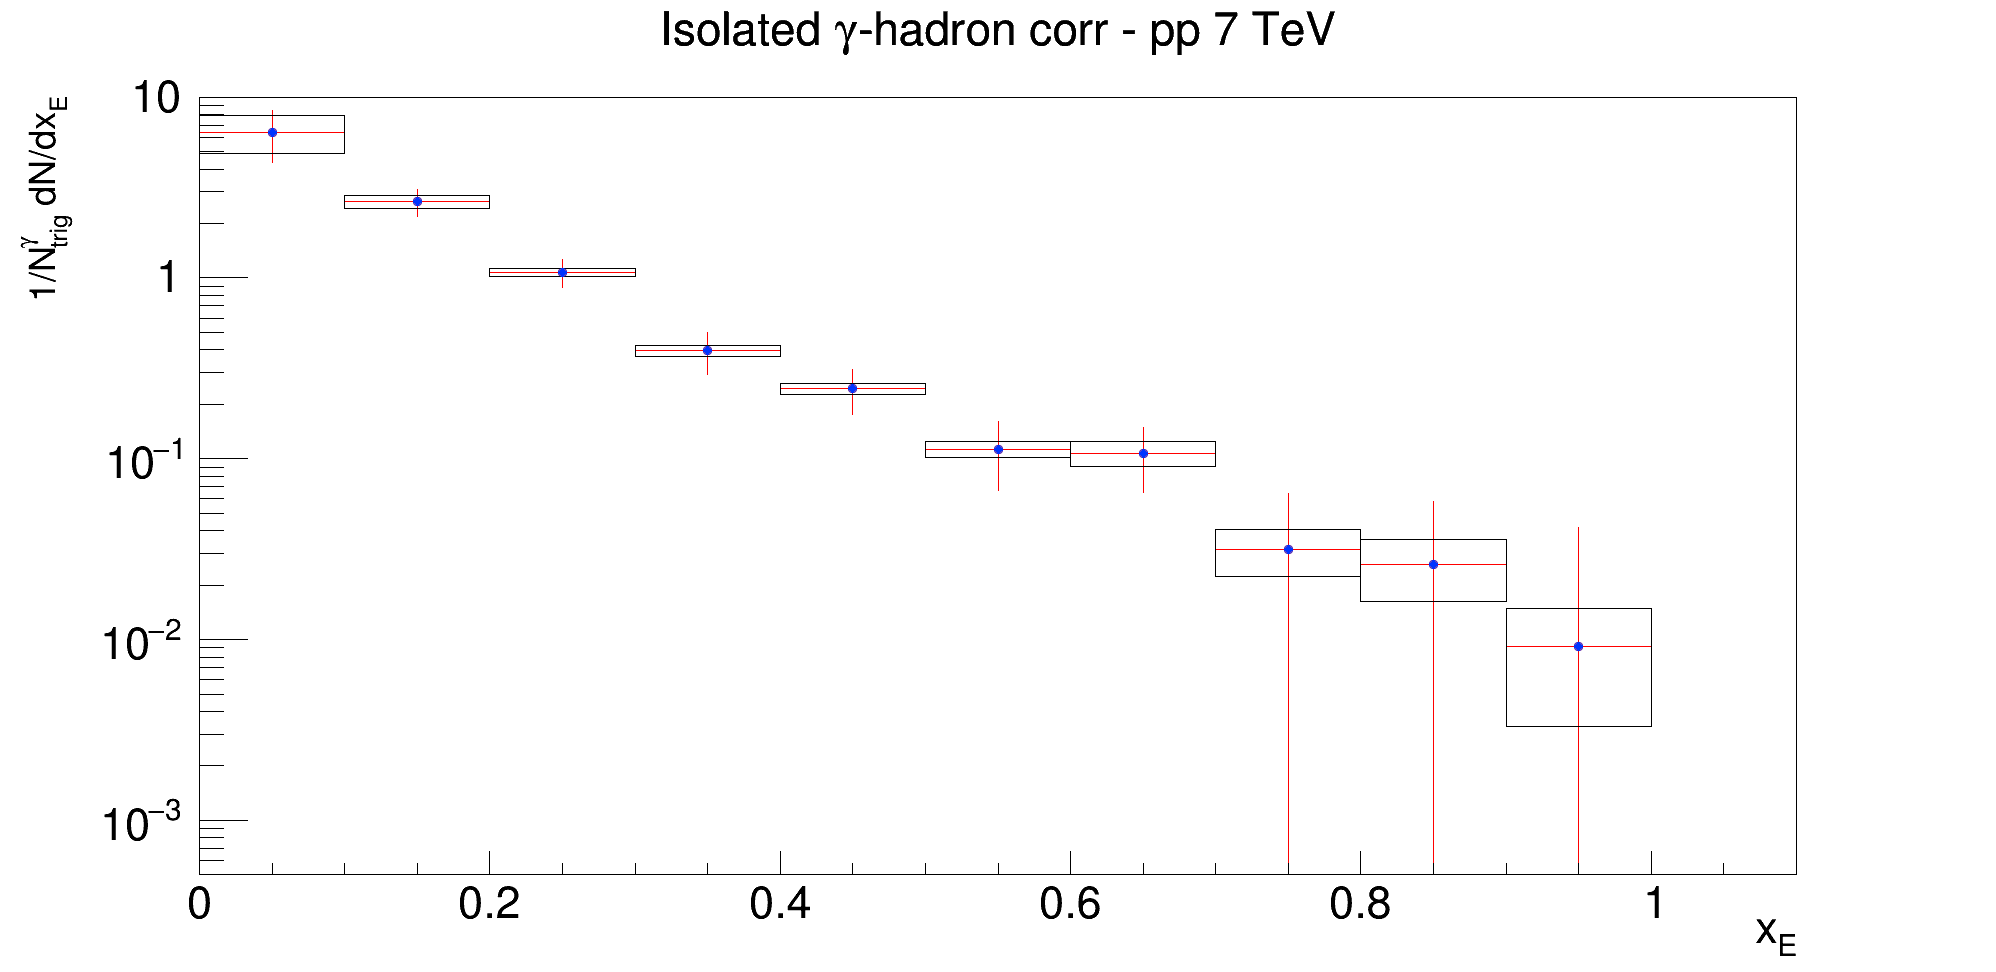

1 0.05
2 0.15
3 0.25
4 0.35
5 0.45
6 0.55
7 0.65
8 0.75
9 0.85
10 0.95
11 1.05
12 1.15
13 1.25
14 1.35
15 1.45
16 1.55
17 1.65
18 1.75
19 1.85
20 1.95
width  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
[0.05, 0.15000000000000002, 0.25, 0.35000000000000003, 0.45, 0.55, 0.6500000000000001, 0.7500000000000001, 0.8500000000000001, 0.9500000000000001, 1.05, 1.1500000000000001, 1.2500000000000002, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.7500000000000002, 1.85, 1.9500000000000002]
TFile**		InputData/pp7TeV.root	
 TFile*		InputData/pp7TeV.root	
  KEY: TH1D	h_xEClusterTot;1	
  KEY: TH1D	h_xEPi0Tot;1	
  KEY: TH1D	h_xEUETot;1	
  KEY: TH1D	h_pClusterTot;1	Total x_{E} distribution for isolated cluster with purity scaling
  KEY: TH1D	h_pPi0Tot;1	Total x_{E} distribution for isolated #pi^{0} with purity scaling
  KEY: TH1D	h_pxEUETot;1	projection de la distribution en xE et pTtrig pour l'UE
  KEY: TH1F	h_xEClus

In [54]:
file = ROOT.TFile("InputData/pp7TeV.root")
file.ls()
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")
c = ROOT.TCanvas("c","c",2000,1000)
pp7.Draw()
pp7_sys.SetFillColor(0)
ROOT.gPad.SetLogy()
pp7_sys.SetLineColor(1)
pp7_sys.Draw("sameE2")
c.Draw()
nbins = pp7.GetSize()-2 
pp7_data = []
pp7_x = []
pp7_error = []
pp7_width = []
#pp7.Scale(6.0)
for i in range (1,nbins+1):
    print i,pp7.GetBinCenter(i)
    pp7_data.append(pp7.GetBinContent(i))
    pp7_x.append(pp7.GetBinCenter(i))
    pp7_error.append(pp7.GetBinError(i))
    pp7_width.append(pp7.GetXaxis().GetBinWidth(i)/2)
print "width ",pp7_width
print pp7_x

AssertionError: 

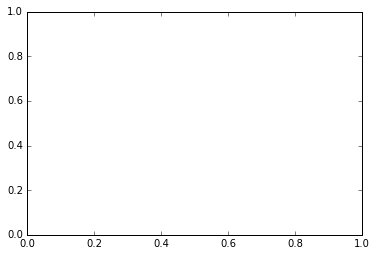

In [55]:
pp_int, pp_error = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',False)
pp_int_sys, pp_error_sys = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',True)
pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)
pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')
%matplotlib inline
plt.errorbar(zT_point, pp_int, yerr=pp_error,xerr=zT_width, fmt='k.',capsize=2)
plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue')
plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.05,fmt='g.-',capsize=2)
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error,fmt='gl',capsize=2)
#plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='k.',capsize=2)
#plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red')
#plt.plot(zT_point,MC_int,'co')
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T}}$",fontsize=20)
plt.xlabel('${z_T}$',fontsize=20)
plt.xlim(xmin = -0.01,xmax=1.0)
plt.ylim(ymin = 0.0001,ymax=20)
#plt.figtext(0.4,0.81,"pythia $\gamma$-j",color='Cyan', fontsize=15)
plt.figtext(0.47,0.76,"pp 7 TeV Gustavo/Astrid",color='Green', fontsize=15)
plt.figtext(0.47,0.811,"pp 5 TeV Berkeley",color='Blue', fontsize=15)
plt.title('Integrated $\gamma$-Hadron Correlation ')
#plt.figure.set_size_inches(18.5, 10.5)
#plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')
plt.gcf()
plt.savefig("pics/Gustavo_FFunction.pdf", bbox_inches='tight')
plt.show()


### Fit Gustavo

In [ ]:
Gus_pp_Fit_Plot = ROOT.TGraphErrors()

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (6):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,pp7_x[izt],pp7_data[izt])
    pp_Fit_Plot.SetPointError(i,0,pp7_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("x_{E}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.85, "#color[8]{pp 7 TeV (Gustavo)}")
latex.DrawLatex(0.55,0.79, "#color[8]{Slope = -7.04 #pm 0.5}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp7_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

In [ ]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.85, "#color[4]{pp 5 TeV (Berkeley)}")
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -10.9 #pm 1.0}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()